# Association Analysis of Filipino Cuisine Ingredients


## Data loading and preview

### Read JSON files

In [1]:
import json
import os


def load_recipes(path="data/recipes"):
    """Combines all recipe data into a single list."""
    files = [file for file in os.listdir(path)]

    recipes = []
    for file in files:
        file_path = os.path.join(path, file)
        with open(file_path, encoding="utf-8") as f:
            recipe_data = json.load(f)
            recipes.extend(recipe_data)

    return recipes


recipes = load_recipes()
recipes[0]

{'link': 'https://www.allrecipes.com/recipe/128699/famous-chicken-adobo/',
 'name': 'Famous Chicken Adobo',
 'ingredients': ['2 tablespoons vegetable oil',
  '1 (3 pound) chicken, cut into pieces',
  '1 large onion, quartered and sliced',
  '2 tablespoons minced garlic',
  ' 2/3  cup low sodium soy sauce',
  ' 1/3  cup white vinegar',
  '1 tablespoon garlic powder',
  '2 teaspoons black pepper',
  '1  bay leaf'],
 'instructions': ['Step 1: Heat vegetable oil in a large skillet over medium-high heat. Cook chicken pieces until golden brown, 2 to 3 minutes per side. Transfer chicken to a plate and set aside.',
  'Step 2: Add onion and garlic to the skillet; cook until softened and brown, about 6 minutes.',
  'Step 3: Pour in soy sauce and vinegar and season with garlic powder, black pepper, and bay leaf.',
  'Step 4: Return chicken to pan, increase heat to high, and bring to a boil. Reduce heat to medium-low, cover, and simmer until chicken is tender and cooked through, 35 to 40 minutes.'

### Convert JSON to DataFrame

In [2]:
import pandas as pd


recipe_df = pd.DataFrame(recipes)
recipe_df.head()

,link,name,ingredients,instructions
0,https://www.allrecipes.com/recipe/128699/famou...,Famous Chicken Adobo,"[2 tablespoons vegetable oil, 1 (3 pound) chic...",[Step 1: Heat vegetable oil in a large skillet...
1,https://www.allrecipes.com/recipe/212994/pinak...,Pinakbet,"[3 tablespoons olive oil, 1 onion, chopped, 2...",[Step 1: Heat oil in a large pot over medium h...
2,https://www.allrecipes.com/recipe/204958/pork-...,Pork Sinigang,"[1 tablespoon vegetable oil, 1 small onion, ch...",[Step 1: Heat vegetable oil in a skillet over ...
3,https://www.allrecipes.com/recipe/270708/lumpi...,Lumpia in the Air Fryer,"[1 pound Italian hot sausage links, 1/2 cup f...",[Step 1: Remove casing from sausage and cook i...
4,https://www.allrecipes.com/recipe/212911/filip...,Filipino Beef Steak,"[4 pounds New York strip steak, sliced thin, 1...",[Step 1: Place sliced beef in a large bowl. Wh...


In [3]:
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4244 entries, 0 to 4243
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   link          4244 non-null   object
 1   name          3898 non-null   object
 2   ingredients   3896 non-null   object
 3   instructions  3872 non-null   object
dtypes: object(4)
memory usage: 132.8+ KB


### Perform EDA on raw dataset

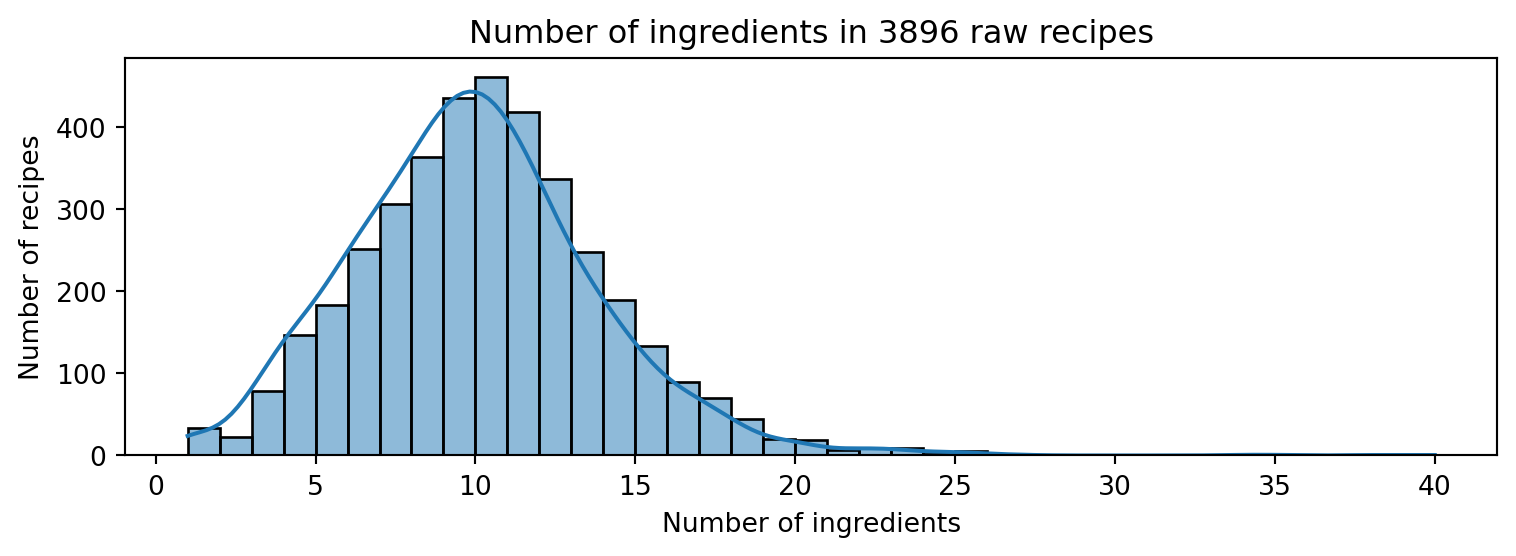

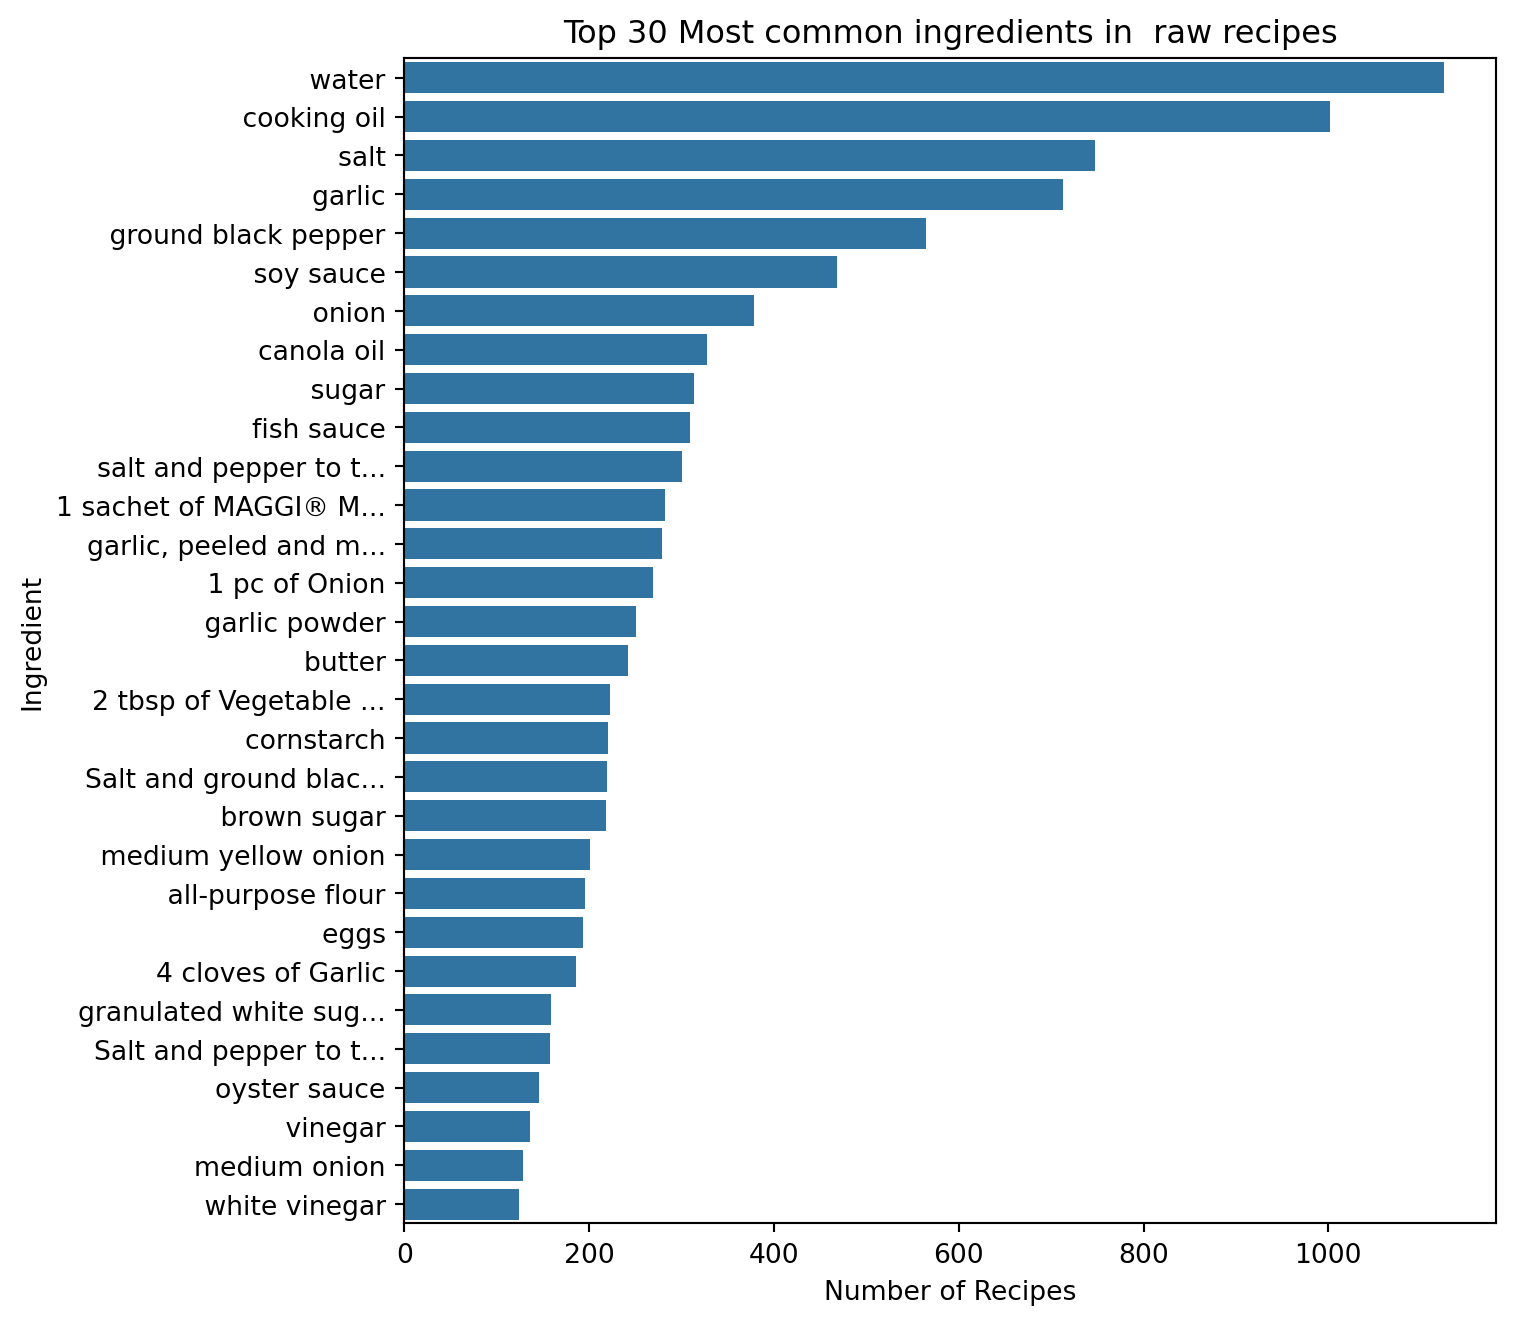

In [4]:
# %matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


def plot_ingredient_count_distribution(
    ingredient_series,
    figsize=(8, 3),
    raw=False,
):
    """Plots the distribution of the number of ingredients in recipes."""
    counts = ingredient_series.dropna().apply(len)
    plt.figure(figsize=figsize)
    sns.histplot(counts, kde=True, binwidth=1)
    plt.title(
        f"Number of ingredients in {len(counts)}"
        f" {'raw' if raw else 'cleaned'} recipes"
    )
    plt.xlabel("Number of ingredients")
    plt.ylabel("Number of recipes")
    plt.tight_layout()
    plt.show()


def plot_common_ingredients(
    ingredient_series,
    n=30,
    most_common=True,
    figsize=(8, 7),
    raw=False,
):
    """Plots the most or least common ingredients."""
    all_ingredients = ingredient_series.dropna().explode()
    ingredient_counts = all_ingredients.value_counts()

    if most_common:
        top_n_ingredients = ingredient_counts.head(n)
    else:
        top_n_ingredients = ingredient_counts.tail(n)

    ylabels = [
        f"{i[:20]:>20}{'...' if len(i) > 20 else ''}"
        for i in top_n_ingredients.index
    ]
    plt.figure(figsize=figsize)
    sns.barplot(x=top_n_ingredients.values, y=ylabels)
    indicator = "Most" if most_common else "Least"
    plt.title(
        f"Top {n} {indicator} common ingredients in"
        f" {' raw' if raw else 'cleaned'} recipes"
    )
    plt.xlabel("Number of Recipes")
    plt.ylabel("Ingredient")
    plt.tight_layout()
    plt.show()


plot_ingredient_count_distribution(recipe_df.ingredients, raw=True)
plot_common_ingredients(recipe_df.ingredients, n=30, most_common=True, raw=True)

## Preprocessing


### Step 0. Remove recipes with no ingredients


In [5]:
def drop_empty_ingredients(recipe_df, column="ingredients"):
    """Drops rows with empty ingredients."""
    new_df = recipe_df.dropna(subset=[column])
    print(f"Dropped {recipe_df.shape[0] - new_df.shape[0]} rows.")
    return new_df


recipe_df = drop_empty_ingredients(recipe_df)

Dropped 348 rows.


In [6]:
def save_ingredients(ingredient_series, path):
    """Saves the ingredients to a TXT file."""
    os.makedirs(os.path.dirname(path), exist_ok=True)

    all_ingredients = ingredient_series.dropna().explode()
    data = sorted(all_ingredients.unique().astype(str))

    with open(path, "w", encoding="utf-8") as file:
        for ingredient in data:
            file.write(f"{ingredient.strip()}\n")


save_ingredients(
    recipe_df.ingredients,
    path="data/preprocess_output/0_raw.txt",
)

### Step 1. Clean ingredient format


In [7]:
import re

from tqdm import tqdm

tqdm.pandas()


def remove_parentheses(ingredient):
    """Removes parentheses and content from ingredient strings."""
    return re.sub(r" ?\([^)]+\)", "", ingredient)


def select_first_option(ingredient):
    """Selects the first option in a string with multiple options."""
    return ingredient.split(" or ")[0]


def clean_ingredient(ingredient):
    """Cleans an ingredient string."""
    ingredient = remove_parentheses(ingredient)
    ingredient = select_first_option(ingredient)
    return ingredient.lower().strip()


recipe_df["cleaned"] = recipe_df.ingredients.progress_apply(
    lambda x: [cleaned for i in x if (cleaned := clean_ingredient(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 107371.01it/s]

In [8]:
save_ingredients(
    recipe_df.cleaned,
    path="data/preprocess_output/1_cleaned.txt",
)

### Step 2. Lemmatize words and remove non-ingredient words


In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")


def correct_noun_pos_tags(token):
    """Corrects the POS tags of specific tokens."""
    outliers = ["cauliflower", "baking"]
    if token.text in outliers:
        token.pos_ = "NOUN"
    return token


def lemmatize_nouns(ingredient):
    """Lemmatizes nouns in an ingredient string."""
    doc = nlp(ingredient)
    lemmas = []
    for token in doc:
        token = correct_noun_pos_tags(token)
        if (
            token.is_alpha
            and not token.is_stop
            and token.pos_ in ["NOUN", "PROPN"]
        ):
            lemmas.append(token.lemma_)
    return " ".join(lemmas)


recipe_df["lemmatized"] = recipe_df.cleaned.progress_apply(
    lambda x: [lemmatized for i in x if (lemmatized := lemmatize_nouns(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

  0%|          | 4/3896 [00:00<02:08, 30.22it/s]

  0%|          | 8/3896 [00:00<02:10, 29.74it/s]

  0%|          | 11/3896 [00:00<02:17, 28.21it/s]

  0%|          | 15/3896 [00:00<02:16, 28.34it/s]

  0%|          | 18/3896 [00:00<02:20, 27.65it/s]

  1%|          | 21/3896 [00:00<02:30, 25.81it/s]

  1%|          | 25/3896 [00:00<02:16, 28.44it/s]

  1%|          | 29/3896 [00:01<02:10, 29.59it/s]

  1%|          | 32/3896 [00:01<02:25, 26.64it/s]

  1%|          | 35/3896 [00:01<02:30, 25.61it/s]

  1%|          | 38/3896 [00:01<02:33, 25.14it/s]

  1%|          | 41/3896 [00:01<02:27, 26.10it/s]

  1%|          | 44/3896 [00:01<02:23, 26.86it/s]

  1%|          | 47/3896 [00:01<02:28, 25.88it/s]

  1%|▏         | 51/3896 [00:01<02:18, 27.77it/s]

  1%|▏         | 54/3896 [00:01<02:17, 28.04it/s]

  1%|▏         | 58/3896 [00:02<02:13, 28.72it/s]

  2%|▏         | 61/3896 [00:02<02:21, 27.18it/s]

  2%|▏         | 64/3896 [00:02<02:22, 26.96it/s]

  2%|▏         | 67/3896 [00:02<02:26, 26.11it/s]

  2%|▏         | 70/3896 [00:02<02:45, 23.17it/s]

  2%|▏         | 73/3896 [00:02<02:34, 24.81it/s]

  2%|▏         | 76/3896 [00:02<02:26, 26.12it/s]

  2%|▏         | 81/3896 [00:02<01:57, 32.50it/s]

  2%|▏         | 85/3896 [00:03<01:55, 33.12it/s]

  2%|▏         | 89/3896 [00:03<01:48, 34.98it/s]

  2%|▏         | 93/3896 [00:03<01:53, 33.41it/s]

  2%|▏         | 97/3896 [00:03<01:50, 34.32it/s]

  3%|▎         | 101/3896 [00:03<02:08, 29.63it/s]

  3%|▎         | 105/3896 [00:03<02:18, 27.39it/s]

  3%|▎         | 109/3896 [00:03<02:05, 30.13it/s]

  3%|▎         | 113/3896 [00:03<02:04, 30.47it/s]

  3%|▎         | 117/3896 [00:04<02:05, 30.18it/s]

  3%|▎         | 121/3896 [00:04<02:00, 31.25it/s]

  3%|▎         | 125/3896 [00:04<01:57, 32.20it/s]

  3%|▎         | 129/3896 [00:04<01:57, 32.06it/s]

  3%|▎         | 133/3896 [00:04<02:12, 28.30it/s]

  3%|▎         | 136/3896 [00:04<02:11, 28.49it/s]

  4%|▎         | 139/3896 [00:04<02:14, 27.90it/s]

  4%|▎         | 142/3896 [00:04<02:13, 28.11it/s]

  4%|▍         | 147/3896 [00:05<01:58, 31.70it/s]

  4%|▍         | 151/3896 [00:05<02:00, 31.02it/s]

  4%|▍         | 155/3896 [00:05<01:56, 32.14it/s]

  4%|▍         | 160/3896 [00:05<01:46, 35.23it/s]

  4%|▍         | 164/3896 [00:05<01:49, 34.20it/s]

  4%|▍         | 168/3896 [00:05<01:53, 32.75it/s]

  4%|▍         | 172/3896 [00:05<01:53, 32.90it/s]

  5%|▍         | 176/3896 [00:05<01:57, 31.75it/s]

  5%|▍         | 180/3896 [00:06<01:59, 31.03it/s]

  5%|▍         | 184/3896 [00:06<01:58, 31.29it/s]

  5%|▍         | 188/3896 [00:06<01:51, 33.29it/s]

  5%|▍         | 192/3896 [00:06<01:52, 32.86it/s]

  5%|▌         | 196/3896 [00:06<01:59, 30.89it/s]

  5%|▌         | 200/3896 [00:06<01:52, 32.92it/s]

  5%|▌         | 206/3896 [00:06<01:40, 36.69it/s]

  5%|▌         | 211/3896 [00:06<01:32, 39.64it/s]

  6%|▌         | 216/3896 [00:07<01:54, 32.19it/s]

  6%|▌         | 220/3896 [00:07<01:56, 31.57it/s]

  6%|▌         | 224/3896 [00:07<01:56, 31.41it/s]

  6%|▌         | 228/3896 [00:07<02:10, 28.12it/s]

  6%|▌         | 234/3896 [00:07<01:47, 33.99it/s]

  6%|▌         | 238/3896 [00:07<01:49, 33.29it/s]

  6%|▌         | 242/3896 [00:07<01:52, 32.46it/s]

  6%|▋         | 246/3896 [00:08<02:00, 30.30it/s]

  6%|▋         | 250/3896 [00:08<02:01, 29.91it/s]

  7%|▋         | 254/3896 [00:08<02:02, 29.82it/s]

  7%|▋         | 258/3896 [00:08<02:03, 29.55it/s]

  7%|▋         | 261/3896 [00:08<02:04, 29.09it/s]

  7%|▋         | 264/3896 [00:08<02:05, 28.97it/s]

  7%|▋         | 269/3896 [00:08<01:46, 34.12it/s]

  7%|▋         | 273/3896 [00:08<01:46, 34.05it/s]

  7%|▋         | 277/3896 [00:09<01:55, 31.24it/s]

  7%|▋         | 281/3896 [00:09<01:51, 32.39it/s]

  7%|▋         | 285/3896 [00:09<01:47, 33.72it/s]

  7%|▋         | 289/3896 [00:09<01:52, 32.16it/s]

  8%|▊         | 294/3896 [00:09<01:44, 34.50it/s]

  8%|▊         | 299/3896 [00:09<01:37, 36.85it/s]

  8%|▊         | 303/3896 [00:09<01:38, 36.46it/s]

  8%|▊         | 307/3896 [00:09<01:37, 36.64it/s]

  8%|▊         | 311/3896 [00:10<01:47, 33.38it/s]

  8%|▊         | 315/3896 [00:10<01:54, 31.29it/s]

  8%|▊         | 319/3896 [00:10<01:52, 31.71it/s]

  8%|▊         | 323/3896 [00:10<01:53, 31.45it/s]

  8%|▊         | 327/3896 [00:10<01:50, 32.34it/s]

  8%|▊         | 331/3896 [00:10<01:59, 29.76it/s]

  9%|▊         | 335/3896 [00:10<01:57, 30.36it/s]

  9%|▊         | 339/3896 [00:11<01:49, 32.35it/s]

  9%|▉         | 343/3896 [00:11<01:52, 31.69it/s]

  9%|▉         | 347/3896 [00:11<01:45, 33.52it/s]

  9%|▉         | 351/3896 [00:11<01:47, 32.84it/s]

  9%|▉         | 355/3896 [00:11<01:42, 34.44it/s]

  9%|▉         | 359/3896 [00:11<01:54, 31.00it/s]

  9%|▉         | 363/3896 [00:11<01:56, 30.45it/s]

  9%|▉         | 368/3896 [00:11<01:49, 32.26it/s]

 10%|▉         | 372/3896 [00:12<01:44, 33.80it/s]

 10%|▉         | 376/3896 [00:12<01:43, 33.86it/s]

 10%|▉         | 380/3896 [00:12<01:51, 31.64it/s]

 10%|▉         | 384/3896 [00:12<01:50, 31.73it/s]

 10%|▉         | 388/3896 [00:12<01:44, 33.54it/s]

 10%|█         | 392/3896 [00:12<01:52, 31.14it/s]

 10%|█         | 396/3896 [00:12<02:02, 28.57it/s]

 10%|█         | 399/3896 [00:12<02:14, 26.08it/s]

 10%|█         | 402/3896 [00:13<02:10, 26.70it/s]

 10%|█         | 405/3896 [00:13<02:17, 25.43it/s]

 10%|█         | 408/3896 [00:13<02:23, 24.31it/s]

 11%|█         | 411/3896 [00:13<02:24, 24.10it/s]

 11%|█         | 416/3896 [00:13<01:54, 30.34it/s]

 11%|█         | 421/3896 [00:13<01:45, 32.85it/s]

 11%|█         | 426/3896 [00:13<01:39, 34.81it/s]

 11%|█         | 430/3896 [00:14<01:52, 30.84it/s]

 11%|█         | 434/3896 [00:14<01:53, 30.45it/s]

 11%|█         | 438/3896 [00:14<01:59, 28.96it/s]

 11%|█▏        | 443/3896 [00:14<01:51, 30.96it/s]

 11%|█▏        | 448/3896 [00:14<01:38, 34.88it/s]

 12%|█▏        | 452/3896 [00:14<01:43, 33.22it/s]

 12%|█▏        | 456/3896 [00:14<01:44, 32.84it/s]

 12%|█▏        | 460/3896 [00:14<01:39, 34.38it/s]

 12%|█▏        | 465/3896 [00:15<01:33, 36.61it/s]

 12%|█▏        | 469/3896 [00:15<01:35, 35.78it/s]

 12%|█▏        | 473/3896 [00:15<01:40, 34.06it/s]

 12%|█▏        | 477/3896 [00:15<01:47, 31.83it/s]

 12%|█▏        | 481/3896 [00:15<01:46, 32.03it/s]

 12%|█▏        | 486/3896 [00:15<01:44, 32.69it/s]

 13%|█▎        | 491/3896 [00:15<01:35, 35.52it/s]

 13%|█▎        | 497/3896 [00:15<01:28, 38.60it/s]

 13%|█▎        | 501/3896 [00:16<01:37, 34.70it/s]

 13%|█▎        | 505/3896 [00:16<01:45, 32.21it/s]

 13%|█▎        | 509/3896 [00:16<01:52, 30.16it/s]

 13%|█▎        | 513/3896 [00:16<02:11, 25.81it/s]

 13%|█▎        | 517/3896 [00:16<02:03, 27.27it/s]

 13%|█▎        | 520/3896 [00:16<02:05, 26.92it/s]

 13%|█▎        | 524/3896 [00:16<01:53, 29.63it/s]

 14%|█▎        | 528/3896 [00:17<01:45, 31.81it/s]

 14%|█▎        | 532/3896 [00:17<01:48, 31.06it/s]

 14%|█▍        | 536/3896 [00:17<01:47, 31.28it/s]

 14%|█▍        | 540/3896 [00:17<01:48, 30.90it/s]

 14%|█▍        | 544/3896 [00:17<01:51, 30.00it/s]

 14%|█▍        | 548/3896 [00:17<01:56, 28.71it/s]

 14%|█▍        | 551/3896 [00:17<02:01, 27.46it/s]

 14%|█▍        | 555/3896 [00:17<01:56, 28.78it/s]

 14%|█▍        | 558/3896 [00:18<01:59, 28.04it/s]

 14%|█▍        | 563/3896 [00:18<01:39, 33.37it/s]

 15%|█▍        | 567/3896 [00:18<01:43, 32.06it/s]

 15%|█▍        | 572/3896 [00:18<01:39, 33.38it/s]

 15%|█▍        | 576/3896 [00:18<01:36, 34.54it/s]

 15%|█▍        | 580/3896 [00:18<01:35, 34.58it/s]

 15%|█▍        | 584/3896 [00:18<01:40, 32.88it/s]

 15%|█▌        | 588/3896 [00:18<01:49, 30.24it/s]

 15%|█▌        | 592/3896 [00:19<01:44, 31.51it/s]

 15%|█▌        | 596/3896 [00:19<01:41, 32.37it/s]

 15%|█▌        | 601/3896 [00:19<01:33, 35.21it/s]

 16%|█▌        | 605/3896 [00:19<01:36, 34.01it/s]

 16%|█▌        | 609/3896 [00:19<01:45, 31.09it/s]

 16%|█▌        | 613/3896 [00:19<01:44, 31.32it/s]

 16%|█▌        | 617/3896 [00:19<01:44, 31.43it/s]

 16%|█▌        | 621/3896 [00:20<01:46, 30.83it/s]

 16%|█▌        | 626/3896 [00:20<01:32, 35.31it/s]

 16%|█▌        | 632/3896 [00:20<01:21, 39.98it/s]

 16%|█▋        | 637/3896 [00:20<01:21, 39.91it/s]

 16%|█▋        | 642/3896 [00:20<01:29, 36.28it/s]

 17%|█▋        | 646/3896 [00:20<01:32, 34.99it/s]

 17%|█▋        | 650/3896 [00:20<01:33, 34.55it/s]

 17%|█▋        | 654/3896 [00:20<01:31, 35.56it/s]

 17%|█▋        | 658/3896 [00:21<01:34, 34.39it/s]

 17%|█▋        | 662/3896 [00:21<01:41, 31.94it/s]

 17%|█▋        | 666/3896 [00:21<01:38, 32.65it/s]

 17%|█▋        | 670/3896 [00:21<01:46, 30.35it/s]

 17%|█▋        | 674/3896 [00:21<01:42, 31.47it/s]

 17%|█▋        | 678/3896 [00:21<01:52, 28.64it/s]

 17%|█▋        | 681/3896 [00:21<02:03, 26.04it/s]

 18%|█▊        | 684/3896 [00:21<02:06, 25.42it/s]

 18%|█▊        | 687/3896 [00:22<02:04, 25.84it/s]

 18%|█▊        | 691/3896 [00:22<01:53, 28.24it/s]

 18%|█▊        | 694/3896 [00:22<01:51, 28.66it/s]

 18%|█▊        | 699/3896 [00:22<01:37, 32.95it/s]

 18%|█▊        | 703/3896 [00:22<01:39, 32.12it/s]

 18%|█▊        | 707/3896 [00:22<01:33, 34.14it/s]

 18%|█▊        | 711/3896 [00:22<01:32, 34.25it/s]

 18%|█▊        | 716/3896 [00:22<01:28, 36.09it/s]

 18%|█▊        | 720/3896 [00:23<01:31, 34.72it/s]

 19%|█▊        | 724/3896 [00:23<01:41, 31.35it/s]

 19%|█▊        | 728/3896 [00:23<01:39, 31.93it/s]

 19%|█▉        | 732/3896 [00:23<01:37, 32.43it/s]

 19%|█▉        | 736/3896 [00:23<01:35, 33.09it/s]

 19%|█▉        | 740/3896 [00:23<01:34, 33.43it/s]

 19%|█▉        | 744/3896 [00:23<01:37, 32.17it/s]

 19%|█▉        | 748/3896 [00:23<01:38, 32.03it/s]

 19%|█▉        | 752/3896 [00:24<01:39, 31.62it/s]

 19%|█▉        | 756/3896 [00:24<01:47, 29.28it/s]

 19%|█▉        | 759/3896 [00:24<01:47, 29.11it/s]

 20%|█▉        | 764/3896 [00:24<01:34, 33.09it/s]

 20%|█▉        | 768/3896 [00:24<01:40, 31.20it/s]

 20%|█▉        | 772/3896 [00:24<01:38, 31.57it/s]

 20%|█▉        | 776/3896 [00:24<01:36, 32.33it/s]

 20%|██        | 780/3896 [00:24<01:36, 32.17it/s]

 20%|██        | 784/3896 [00:25<01:48, 28.55it/s]

 20%|██        | 788/3896 [00:25<01:45, 29.38it/s]

 20%|██        | 792/3896 [00:25<01:47, 28.74it/s]

 20%|██        | 795/3896 [00:25<01:50, 27.96it/s]

 20%|██        | 798/3896 [00:25<01:59, 26.01it/s]

 21%|██        | 802/3896 [00:25<01:49, 28.30it/s]

 21%|██        | 806/3896 [00:25<01:47, 28.79it/s]

 21%|██        | 810/3896 [00:26<01:42, 30.25it/s]

 21%|██        | 814/3896 [00:26<01:53, 27.18it/s]

 21%|██        | 817/3896 [00:26<01:52, 27.35it/s]

 21%|██        | 820/3896 [00:26<01:51, 27.54it/s]

 21%|██        | 824/3896 [00:26<01:44, 29.52it/s]

 21%|██        | 827/3896 [00:26<01:47, 28.48it/s]

 21%|██▏       | 830/3896 [00:26<01:46, 28.86it/s]

 21%|██▏       | 833/3896 [00:26<01:49, 27.96it/s]

 21%|██▏       | 836/3896 [00:26<01:52, 27.30it/s]

 22%|██▏       | 839/3896 [00:27<01:58, 25.85it/s]

 22%|██▏       | 842/3896 [00:27<01:59, 25.59it/s]

 22%|██▏       | 845/3896 [00:27<01:58, 25.66it/s]

 22%|██▏       | 849/3896 [00:27<01:47, 28.44it/s]

 22%|██▏       | 854/3896 [00:27<01:38, 30.81it/s]

 22%|██▏       | 858/3896 [00:27<01:42, 29.58it/s]

 22%|██▏       | 861/3896 [00:27<01:46, 28.59it/s]

 22%|██▏       | 865/3896 [00:27<01:42, 29.45it/s]

 22%|██▏       | 868/3896 [00:28<01:43, 29.25it/s]

 22%|██▏       | 871/3896 [00:28<01:44, 28.97it/s]

 22%|██▏       | 875/3896 [00:28<01:43, 29.24it/s]

 23%|██▎       | 878/3896 [00:28<01:51, 27.10it/s]

 23%|██▎       | 882/3896 [00:28<01:45, 28.54it/s]

 23%|██▎       | 885/3896 [00:28<01:54, 26.41it/s]

 23%|██▎       | 889/3896 [00:28<01:45, 28.51it/s]

 23%|██▎       | 892/3896 [00:28<01:44, 28.63it/s]

 23%|██▎       | 895/3896 [00:29<01:45, 28.51it/s]

 23%|██▎       | 898/3896 [00:29<01:48, 27.71it/s]

 23%|██▎       | 901/3896 [00:29<01:49, 27.31it/s]

 23%|██▎       | 905/3896 [00:29<01:42, 29.12it/s]

 23%|██▎       | 908/3896 [00:29<01:43, 28.93it/s]

 23%|██▎       | 911/3896 [00:29<01:43, 28.89it/s]

 23%|██▎       | 914/3896 [00:29<01:44, 28.67it/s]

 24%|██▎       | 917/3896 [00:29<01:44, 28.46it/s]

 24%|██▎       | 920/3896 [00:29<01:44, 28.52it/s]

 24%|██▎       | 924/3896 [00:30<01:43, 28.72it/s]

 24%|██▍       | 927/3896 [00:30<01:51, 26.55it/s]

 24%|██▍       | 931/3896 [00:30<01:47, 27.54it/s]

 24%|██▍       | 935/3896 [00:30<01:45, 28.08it/s]

 24%|██▍       | 938/3896 [00:30<01:48, 27.27it/s]

 24%|██▍       | 941/3896 [00:30<01:58, 24.99it/s]

 24%|██▍       | 944/3896 [00:30<02:15, 21.80it/s]

 24%|██▍       | 947/3896 [00:31<02:32, 19.33it/s]

 24%|██▍       | 950/3896 [00:31<02:29, 19.75it/s]

 24%|██▍       | 953/3896 [00:31<02:28, 19.87it/s]

 25%|██▍       | 956/3896 [00:31<02:17, 21.37it/s]

 25%|██▍       | 960/3896 [00:31<02:02, 23.92it/s]

 25%|██▍       | 963/3896 [00:31<02:02, 23.88it/s]

 25%|██▍       | 966/3896 [00:31<01:59, 24.48it/s]

 25%|██▍       | 969/3896 [00:32<02:09, 22.52it/s]

 25%|██▍       | 972/3896 [00:32<02:07, 22.94it/s]

 25%|██▌       | 975/3896 [00:32<02:03, 23.60it/s]

 25%|██▌       | 978/3896 [00:32<02:00, 24.30it/s]

 25%|██▌       | 982/3896 [00:32<01:49, 26.62it/s]

 25%|██▌       | 985/3896 [00:32<01:58, 24.56it/s]

 25%|██▌       | 988/3896 [00:32<01:54, 25.32it/s]

 25%|██▌       | 991/3896 [00:32<02:02, 23.67it/s]

 26%|██▌       | 994/3896 [00:33<01:59, 24.23it/s]

 26%|██▌       | 998/3896 [00:33<01:43, 27.88it/s]

 26%|██▌       | 1001/3896 [00:33<01:43, 27.97it/s]

 26%|██▌       | 1004/3896 [00:33<01:42, 28.10it/s]

 26%|██▌       | 1008/3896 [00:33<01:39, 28.95it/s]

 26%|██▌       | 1012/3896 [00:33<01:37, 29.66it/s]

 26%|██▌       | 1016/3896 [00:33<01:35, 30.18it/s]

 26%|██▌       | 1020/3896 [00:33<01:35, 30.00it/s]

 26%|██▋       | 1024/3896 [00:34<01:32, 30.94it/s]

 26%|██▋       | 1028/3896 [00:34<01:38, 29.13it/s]

 26%|██▋       | 1032/3896 [00:34<01:35, 29.85it/s]

 27%|██▋       | 1036/3896 [00:34<01:38, 29.05it/s]

 27%|██▋       | 1039/3896 [00:34<01:43, 27.61it/s]

 27%|██▋       | 1042/3896 [00:34<01:45, 27.01it/s]

 27%|██▋       | 1045/3896 [00:34<01:53, 25.08it/s]

 27%|██▋       | 1048/3896 [00:34<01:52, 25.32it/s]

 27%|██▋       | 1051/3896 [00:35<01:56, 24.38it/s]

 27%|██▋       | 1055/3896 [00:35<01:47, 26.55it/s]

 27%|██▋       | 1058/3896 [00:35<01:48, 26.18it/s]

 27%|██▋       | 1062/3896 [00:35<01:35, 29.67it/s]

 27%|██▋       | 1066/3896 [00:35<01:37, 29.06it/s]

 27%|██▋       | 1070/3896 [00:35<01:33, 30.35it/s]

 28%|██▊       | 1074/3896 [00:35<01:34, 29.74it/s]

 28%|██▊       | 1078/3896 [00:35<01:35, 29.65it/s]

 28%|██▊       | 1081/3896 [00:36<01:41, 27.73it/s]

 28%|██▊       | 1085/3896 [00:36<01:39, 28.12it/s]

 28%|██▊       | 1089/3896 [00:36<01:33, 30.15it/s]

 28%|██▊       | 1093/3896 [00:36<01:31, 30.63it/s]

 28%|██▊       | 1097/3896 [00:36<01:28, 31.66it/s]

 28%|██▊       | 1102/3896 [00:36<01:22, 33.73it/s]

 28%|██▊       | 1106/3896 [00:36<01:27, 32.04it/s]

 28%|██▊       | 1110/3896 [00:37<01:41, 27.40it/s]

 29%|██▊       | 1114/3896 [00:37<01:39, 27.99it/s]

 29%|██▊       | 1117/3896 [00:37<01:39, 28.06it/s]

 29%|██▉       | 1121/3896 [00:37<01:35, 29.17it/s]

 29%|██▉       | 1125/3896 [00:37<01:32, 29.99it/s]

 29%|██▉       | 1129/3896 [00:37<01:30, 30.43it/s]

 29%|██▉       | 1133/3896 [00:37<01:29, 30.93it/s]

 29%|██▉       | 1137/3896 [00:37<01:29, 30.69it/s]

 29%|██▉       | 1141/3896 [00:38<01:40, 27.52it/s]

 29%|██▉       | 1144/3896 [00:38<01:40, 27.48it/s]

 29%|██▉       | 1147/3896 [00:38<01:43, 26.54it/s]

 30%|██▉       | 1151/3896 [00:38<01:37, 28.13it/s]

 30%|██▉       | 1154/3896 [00:38<01:43, 26.60it/s]

 30%|██▉       | 1157/3896 [00:38<01:43, 26.41it/s]

 30%|██▉       | 1160/3896 [00:38<01:47, 25.49it/s]

 30%|██▉       | 1164/3896 [00:38<01:42, 26.69it/s]

 30%|██▉       | 1167/3896 [00:39<01:43, 26.49it/s]

 30%|███       | 1170/3896 [00:39<01:45, 25.88it/s]

 30%|███       | 1174/3896 [00:39<01:36, 28.34it/s]

 30%|███       | 1178/3896 [00:39<01:31, 29.66it/s]

 30%|███       | 1182/3896 [00:39<01:29, 30.36it/s]

 30%|███       | 1187/3896 [00:39<01:21, 33.21it/s]

 31%|███       | 1191/3896 [00:39<01:23, 32.35it/s]

 31%|███       | 1195/3896 [00:39<01:18, 34.21it/s]

 31%|███       | 1199/3896 [00:40<01:18, 34.35it/s]

 31%|███       | 1203/3896 [00:40<01:27, 30.79it/s]

 31%|███       | 1207/3896 [00:40<01:34, 28.38it/s]

 31%|███       | 1210/3896 [00:40<01:34, 28.43it/s]

 31%|███       | 1213/3896 [00:40<01:34, 28.51it/s]

 31%|███       | 1217/3896 [00:40<01:32, 28.85it/s]

 31%|███▏      | 1221/3896 [00:40<01:31, 29.40it/s]

 31%|███▏      | 1225/3896 [00:40<01:28, 30.11it/s]

 32%|███▏      | 1229/3896 [00:41<01:31, 29.03it/s]

 32%|███▏      | 1232/3896 [00:41<01:32, 28.77it/s]

 32%|███▏      | 1235/3896 [00:41<01:38, 26.95it/s]

 32%|███▏      | 1239/3896 [00:41<01:33, 28.43it/s]

 32%|███▏      | 1242/3896 [00:41<01:40, 26.50it/s]

 32%|███▏      | 1245/3896 [00:41<01:42, 25.75it/s]

 32%|███▏      | 1249/3896 [00:41<01:41, 26.07it/s]

 32%|███▏      | 1252/3896 [00:42<01:41, 26.10it/s]

 32%|███▏      | 1255/3896 [00:42<01:39, 26.52it/s]

 32%|███▏      | 1258/3896 [00:42<01:37, 26.92it/s]

 32%|███▏      | 1261/3896 [00:42<01:42, 25.81it/s]

 32%|███▏      | 1264/3896 [00:42<01:40, 26.29it/s]

 33%|███▎      | 1267/3896 [00:42<01:42, 25.56it/s]

 33%|███▎      | 1271/3896 [00:42<01:33, 28.06it/s]

 33%|███▎      | 1275/3896 [00:42<01:32, 28.48it/s]

 33%|███▎      | 1278/3896 [00:42<01:33, 27.86it/s]

 33%|███▎      | 1281/3896 [00:43<01:35, 27.28it/s]

 33%|███▎      | 1284/3896 [00:43<01:33, 27.85it/s]

 33%|███▎      | 1287/3896 [00:43<01:35, 27.33it/s]

 33%|███▎      | 1290/3896 [00:43<01:36, 27.08it/s]

 33%|███▎      | 1293/3896 [00:43<01:55, 22.52it/s]

 33%|███▎      | 1296/3896 [00:43<01:47, 24.28it/s]

 33%|███▎      | 1299/3896 [00:43<02:06, 20.50it/s]

 33%|███▎      | 1302/3896 [00:44<02:05, 20.63it/s]

 33%|███▎      | 1305/3896 [00:44<01:55, 22.42it/s]

 34%|███▎      | 1308/3896 [00:44<01:55, 22.48it/s]

 34%|███▎      | 1311/3896 [00:44<01:47, 24.10it/s]

 34%|███▎      | 1314/3896 [00:44<01:45, 24.56it/s]

 34%|███▍      | 1318/3896 [00:44<01:34, 27.42it/s]

 34%|███▍      | 1322/3896 [00:44<01:25, 30.18it/s]

 34%|███▍      | 1326/3896 [00:44<01:21, 31.49it/s]

 34%|███▍      | 1331/3896 [00:44<01:15, 33.96it/s]

 34%|███▍      | 1335/3896 [00:45<01:13, 34.69it/s]

 34%|███▍      | 1340/3896 [00:45<01:08, 37.25it/s]

 34%|███▍      | 1344/3896 [00:45<01:31, 27.96it/s]

 35%|███▍      | 1348/3896 [00:45<01:43, 24.70it/s]

 35%|███▍      | 1351/3896 [00:45<01:45, 24.05it/s]

 35%|███▍      | 1354/3896 [00:45<01:48, 23.53it/s]

 35%|███▍      | 1357/3896 [00:46<01:43, 24.62it/s]

 35%|███▍      | 1361/3896 [00:46<01:35, 26.59it/s]

 35%|███▌      | 1364/3896 [00:46<01:41, 24.97it/s]

 35%|███▌      | 1368/3896 [00:46<01:35, 26.38it/s]

 35%|███▌      | 1371/3896 [00:46<01:33, 26.96it/s]

 35%|███▌      | 1374/3896 [00:46<01:33, 26.97it/s]

 35%|███▌      | 1377/3896 [00:46<01:33, 26.89it/s]

 35%|███▌      | 1380/3896 [00:46<01:39, 25.32it/s]

 35%|███▌      | 1383/3896 [00:47<01:41, 24.66it/s]

 36%|███▌      | 1386/3896 [00:47<01:42, 24.52it/s]

 36%|███▌      | 1390/3896 [00:47<01:36, 26.04it/s]

 36%|███▌      | 1394/3896 [00:47<01:30, 27.76it/s]

 36%|███▌      | 1397/3896 [00:47<01:34, 26.53it/s]

 36%|███▌      | 1401/3896 [00:47<01:30, 27.45it/s]

 36%|███▌      | 1404/3896 [00:47<01:38, 25.19it/s]

 36%|███▌      | 1407/3896 [00:47<01:35, 26.10it/s]

 36%|███▌      | 1411/3896 [00:48<01:30, 27.32it/s]

 36%|███▋      | 1414/3896 [00:48<01:32, 26.84it/s]

 36%|███▋      | 1417/3896 [00:48<01:30, 27.28it/s]

 36%|███▋      | 1420/3896 [00:48<01:31, 27.09it/s]

 37%|███▋      | 1423/3896 [00:48<01:39, 24.82it/s]

 37%|███▋      | 1426/3896 [00:48<01:37, 25.37it/s]

 37%|███▋      | 1429/3896 [00:48<01:34, 26.21it/s]

 37%|███▋      | 1432/3896 [00:48<01:31, 26.98it/s]

 37%|███▋      | 1435/3896 [00:48<01:29, 27.35it/s]

 37%|███▋      | 1438/3896 [00:49<01:31, 26.79it/s]

 37%|███▋      | 1441/3896 [00:49<01:29, 27.42it/s]

 37%|███▋      | 1446/3896 [00:49<01:22, 29.71it/s]

 37%|███▋      | 1450/3896 [00:49<01:25, 28.69it/s]

 37%|███▋      | 1455/3896 [00:49<01:16, 31.85it/s]

 37%|███▋      | 1459/3896 [00:49<01:17, 31.25it/s]

 38%|███▊      | 1463/3896 [00:49<01:30, 26.87it/s]

 38%|███▊      | 1466/3896 [00:50<01:33, 26.06it/s]

 38%|███▊      | 1470/3896 [00:50<01:23, 29.00it/s]

 38%|███▊      | 1474/3896 [00:50<01:23, 29.09it/s]

 38%|███▊      | 1478/3896 [00:50<01:19, 30.24it/s]

 38%|███▊      | 1482/3896 [00:50<01:16, 31.39it/s]

 38%|███▊      | 1486/3896 [00:50<01:20, 29.85it/s]

 38%|███▊      | 1490/3896 [00:50<01:17, 30.92it/s]

 38%|███▊      | 1494/3896 [00:50<01:14, 32.17it/s]

 38%|███▊      | 1498/3896 [00:51<01:16, 31.35it/s]

 39%|███▊      | 1502/3896 [00:51<01:17, 30.84it/s]

 39%|███▊      | 1506/3896 [00:51<01:14, 31.98it/s]

 39%|███▉      | 1510/3896 [00:51<01:14, 31.84it/s]

 39%|███▉      | 1514/3896 [00:51<01:14, 31.97it/s]

 39%|███▉      | 1518/3896 [00:51<01:22, 28.94it/s]

 39%|███▉      | 1522/3896 [00:51<01:19, 29.94it/s]

 39%|███▉      | 1526/3896 [00:52<01:33, 25.41it/s]

 39%|███▉      | 1529/3896 [00:52<01:34, 25.06it/s]

 39%|███▉      | 1532/3896 [00:52<01:34, 24.94it/s]

 39%|███▉      | 1536/3896 [00:52<01:28, 26.74it/s]

 40%|███▉      | 1539/3896 [00:52<01:35, 24.71it/s]

 40%|███▉      | 1542/3896 [00:52<01:33, 25.12it/s]

 40%|███▉      | 1546/3896 [00:52<01:25, 27.41it/s]

 40%|███▉      | 1549/3896 [00:52<01:24, 27.77it/s]

 40%|███▉      | 1552/3896 [00:53<01:25, 27.45it/s]

 40%|███▉      | 1555/3896 [00:53<01:26, 26.99it/s]

 40%|████      | 1559/3896 [00:53<01:23, 28.10it/s]

 40%|████      | 1563/3896 [00:53<01:20, 28.83it/s]

 40%|████      | 1566/3896 [00:53<01:23, 27.84it/s]

 40%|████      | 1570/3896 [00:53<01:21, 28.56it/s]

 40%|████      | 1573/3896 [00:53<01:21, 28.57it/s]

 40%|████      | 1577/3896 [00:53<01:18, 29.62it/s]

 41%|████      | 1580/3896 [00:54<01:20, 28.63it/s]

 41%|████      | 1584/3896 [00:54<01:24, 27.46it/s]

 41%|████      | 1588/3896 [00:54<01:20, 28.70it/s]

 41%|████      | 1591/3896 [00:54<01:19, 28.83it/s]

 41%|████      | 1595/3896 [00:54<01:15, 30.53it/s]

 41%|████      | 1599/3896 [00:54<01:11, 32.33it/s]

 41%|████      | 1603/3896 [00:54<01:09, 33.20it/s]

 41%|████      | 1607/3896 [00:54<01:08, 33.56it/s]

 41%|████▏     | 1612/3896 [00:54<01:02, 36.80it/s]

 41%|████▏     | 1616/3896 [00:55<01:05, 35.02it/s]

 42%|████▏     | 1620/3896 [00:55<01:09, 32.79it/s]

 42%|████▏     | 1624/3896 [00:55<01:09, 32.48it/s]

 42%|████▏     | 1628/3896 [00:55<01:10, 32.16it/s]

 42%|████▏     | 1632/3896 [00:55<01:09, 32.77it/s]

 42%|████▏     | 1636/3896 [00:55<01:10, 32.05it/s]

 42%|████▏     | 1640/3896 [00:55<01:10, 31.82it/s]

 42%|████▏     | 1644/3896 [00:55<01:11, 31.67it/s]

 42%|████▏     | 1648/3896 [00:56<01:14, 30.21it/s]

 42%|████▏     | 1652/3896 [00:56<01:19, 28.11it/s]

 42%|████▏     | 1655/3896 [00:56<01:19, 28.27it/s]

 43%|████▎     | 1658/3896 [00:56<01:22, 27.02it/s]

 43%|████▎     | 1662/3896 [00:56<01:18, 28.51it/s]

 43%|████▎     | 1666/3896 [00:56<01:14, 29.94it/s]

 43%|████▎     | 1670/3896 [00:56<01:10, 31.43it/s]

 43%|████▎     | 1676/3896 [00:56<00:59, 37.46it/s]

 43%|████▎     | 1680/3896 [00:57<01:02, 35.69it/s]

 43%|████▎     | 1684/3896 [00:57<01:05, 33.79it/s]

 43%|████▎     | 1688/3896 [00:57<01:17, 28.60it/s]

 43%|████▎     | 1692/3896 [00:57<01:24, 26.06it/s]

 44%|████▎     | 1695/3896 [00:57<01:31, 23.99it/s]

 44%|████▎     | 1698/3896 [00:57<01:28, 24.88it/s]

 44%|████▎     | 1701/3896 [00:58<01:33, 23.59it/s]

 44%|████▎     | 1704/3896 [00:58<01:27, 24.94it/s]

 44%|████▍     | 1709/3896 [00:58<01:12, 29.99it/s]

 44%|████▍     | 1713/3896 [00:58<01:14, 29.43it/s]

 44%|████▍     | 1717/3896 [00:58<01:15, 28.70it/s]

 44%|████▍     | 1720/3896 [00:58<01:17, 28.15it/s]

 44%|████▍     | 1723/3896 [00:58<01:16, 28.23it/s]

 44%|████▍     | 1727/3896 [00:58<01:13, 29.33it/s]

 44%|████▍     | 1730/3896 [00:59<01:26, 25.13it/s]

 44%|████▍     | 1733/3896 [00:59<01:24, 25.66it/s]

 45%|████▍     | 1737/3896 [00:59<01:22, 26.12it/s]

 45%|████▍     | 1741/3896 [00:59<01:17, 27.70it/s]

 45%|████▍     | 1745/3896 [00:59<01:14, 28.90it/s]

 45%|████▍     | 1749/3896 [00:59<01:12, 29.78it/s]

 45%|████▍     | 1753/3896 [00:59<01:12, 29.69it/s]

 45%|████▌     | 1758/3896 [00:59<01:04, 32.89it/s]

 45%|████▌     | 1762/3896 [01:00<01:10, 30.45it/s]

 45%|████▌     | 1766/3896 [01:00<01:07, 31.41it/s]

 45%|████▌     | 1770/3896 [01:00<01:06, 32.20it/s]

 46%|████▌     | 1774/3896 [01:00<01:08, 30.79it/s]

 46%|████▌     | 1778/3896 [01:00<01:15, 28.01it/s]

 46%|████▌     | 1782/3896 [01:00<01:11, 29.67it/s]

 46%|████▌     | 1786/3896 [01:00<01:07, 31.04it/s]

 46%|████▌     | 1790/3896 [01:01<01:07, 31.22it/s]

 46%|████▌     | 1795/3896 [01:01<00:59, 35.52it/s]

 46%|████▌     | 1799/3896 [01:01<01:00, 34.44it/s]

 46%|████▋     | 1803/3896 [01:01<01:03, 32.98it/s]

 46%|████▋     | 1808/3896 [01:01<00:58, 35.69it/s]

 47%|████▋     | 1812/3896 [01:01<01:00, 34.26it/s]

 47%|████▋     | 1816/3896 [01:01<01:04, 32.47it/s]

 47%|████▋     | 1820/3896 [01:01<01:06, 31.44it/s]

 47%|████▋     | 1824/3896 [01:02<01:08, 30.47it/s]

 47%|████▋     | 1828/3896 [01:02<01:10, 29.33it/s]

 47%|████▋     | 1832/3896 [01:02<01:07, 30.76it/s]

 47%|████▋     | 1836/3896 [01:02<01:06, 31.11it/s]

 47%|████▋     | 1840/3896 [01:02<01:07, 30.40it/s]

 47%|████▋     | 1844/3896 [01:02<01:20, 25.64it/s]

 47%|████▋     | 1847/3896 [01:02<01:21, 25.06it/s]

 48%|████▊     | 1851/3896 [01:03<01:14, 27.54it/s]

 48%|████▊     | 1854/3896 [01:03<01:14, 27.40it/s]

 48%|████▊     | 1858/3896 [01:03<01:08, 29.76it/s]

 48%|████▊     | 1862/3896 [01:03<01:08, 29.84it/s]

 48%|████▊     | 1866/3896 [01:03<01:07, 30.15it/s]

 48%|████▊     | 1870/3896 [01:03<01:12, 27.78it/s]

 48%|████▊     | 1874/3896 [01:03<01:06, 30.60it/s]

 48%|████▊     | 1878/3896 [01:03<01:01, 32.93it/s]

 48%|████▊     | 1882/3896 [01:03<00:57, 34.76it/s]

 48%|████▊     | 1887/3896 [01:04<00:54, 37.20it/s]

 49%|████▊     | 1891/3896 [01:04<00:54, 36.47it/s]

 49%|████▊     | 1895/3896 [01:04<00:58, 33.94it/s]

 49%|████▊     | 1899/3896 [01:04<00:56, 35.11it/s]

 49%|████▉     | 1903/3896 [01:04<00:55, 35.96it/s]

 49%|████▉     | 1907/3896 [01:04<01:02, 31.81it/s]

 49%|████▉     | 1911/3896 [01:04<01:07, 29.29it/s]

 49%|████▉     | 1915/3896 [01:05<01:07, 29.30it/s]

 49%|████▉     | 1919/3896 [01:05<01:10, 28.04it/s]

 49%|████▉     | 1923/3896 [01:05<01:04, 30.36it/s]

 49%|████▉     | 1927/3896 [01:05<01:02, 31.51it/s]

 50%|████▉     | 1931/3896 [01:05<01:00, 32.45it/s]

 50%|████▉     | 1935/3896 [01:05<00:59, 32.85it/s]

 50%|████▉     | 1940/3896 [01:05<00:56, 34.78it/s]

 50%|████▉     | 1944/3896 [01:05<00:54, 35.84it/s]

 50%|█████     | 1948/3896 [01:06<01:00, 32.32it/s]

 50%|█████     | 1953/3896 [01:06<00:53, 36.13it/s]

 50%|█████     | 1957/3896 [01:06<00:52, 36.78it/s]

 50%|█████     | 1961/3896 [01:06<00:52, 36.97it/s]

 50%|█████     | 1965/3896 [01:06<00:52, 37.07it/s]

 51%|█████     | 1969/3896 [01:06<00:51, 37.52it/s]

 51%|█████     | 1973/3896 [01:06<00:53, 35.66it/s]

 51%|█████     | 1978/3896 [01:06<00:50, 38.01it/s]

 51%|█████     | 1982/3896 [01:06<00:50, 37.63it/s]

 51%|█████     | 1986/3896 [01:07<00:53, 35.87it/s]

 51%|█████     | 1990/3896 [01:07<00:59, 32.19it/s]

 51%|█████     | 1994/3896 [01:07<00:56, 33.81it/s]

 51%|█████▏    | 1998/3896 [01:07<00:57, 33.05it/s]

 51%|█████▏    | 2002/3896 [01:07<00:55, 34.31it/s]

 51%|█████▏    | 2006/3896 [01:07<00:58, 32.38it/s]

 52%|█████▏    | 2010/3896 [01:07<00:55, 33.91it/s]

 52%|█████▏    | 2014/3896 [01:07<00:54, 34.32it/s]

 52%|█████▏    | 2018/3896 [01:07<00:55, 33.99it/s]

 52%|█████▏    | 2022/3896 [01:08<00:56, 33.21it/s]

 52%|█████▏    | 2026/3896 [01:08<00:56, 32.90it/s]

 52%|█████▏    | 2030/3896 [01:08<01:01, 30.48it/s]

 52%|█████▏    | 2034/3896 [01:08<01:00, 30.73it/s]

 52%|█████▏    | 2038/3896 [01:08<00:59, 31.05it/s]

 52%|█████▏    | 2044/3896 [01:08<00:50, 37.00it/s]

 53%|█████▎    | 2049/3896 [01:08<00:47, 39.13it/s]

 53%|█████▎    | 2053/3896 [01:08<00:49, 37.09it/s]

 53%|█████▎    | 2057/3896 [01:09<00:49, 37.45it/s]

 53%|█████▎    | 2061/3896 [01:09<00:53, 34.53it/s]

 53%|█████▎    | 2065/3896 [01:09<00:55, 32.70it/s]

 53%|█████▎    | 2069/3896 [01:09<00:58, 31.46it/s]

 53%|█████▎    | 2073/3896 [01:09<00:55, 33.10it/s]

 53%|█████▎    | 2077/3896 [01:09<00:52, 34.57it/s]

 53%|█████▎    | 2081/3896 [01:09<00:53, 33.75it/s]

 54%|█████▎    | 2085/3896 [01:09<00:55, 32.46it/s]

 54%|█████▎    | 2089/3896 [01:10<00:52, 34.10it/s]

 54%|█████▎    | 2093/3896 [01:10<00:55, 32.41it/s]

 54%|█████▍    | 2097/3896 [01:10<00:54, 33.14it/s]

 54%|█████▍    | 2103/3896 [01:10<00:47, 37.39it/s]

 54%|█████▍    | 2107/3896 [01:10<00:48, 37.06it/s]

 54%|█████▍    | 2111/3896 [01:10<00:47, 37.32it/s]

 54%|█████▍    | 2117/3896 [01:10<00:45, 38.71it/s]

 54%|█████▍    | 2121/3896 [01:10<00:47, 37.52it/s]

 55%|█████▍    | 2126/3896 [01:11<00:44, 40.12it/s]

 55%|█████▍    | 2131/3896 [01:11<00:44, 39.83it/s]

 55%|█████▍    | 2136/3896 [01:11<00:43, 40.61it/s]

 55%|█████▍    | 2141/3896 [01:11<00:48, 35.92it/s]

 55%|█████▌    | 2145/3896 [01:11<00:48, 35.87it/s]

 55%|█████▌    | 2150/3896 [01:11<00:46, 37.24it/s]

 55%|█████▌    | 2155/3896 [01:11<00:48, 36.05it/s]

 55%|█████▌    | 2159/3896 [01:11<00:48, 35.74it/s]

 56%|█████▌    | 2163/3896 [01:12<00:47, 36.57it/s]

 56%|█████▌    | 2168/3896 [01:12<00:46, 37.32it/s]

 56%|█████▌    | 2173/3896 [01:12<00:45, 38.08it/s]

 56%|█████▌    | 2178/3896 [01:12<00:44, 38.48it/s]

 56%|█████▌    | 2184/3896 [01:12<00:41, 41.36it/s]

 56%|█████▌    | 2189/3896 [01:12<00:44, 38.03it/s]

 56%|█████▋    | 2194/3896 [01:12<00:43, 39.23it/s]

 56%|█████▋    | 2198/3896 [01:12<00:46, 36.86it/s]

 57%|█████▋    | 2202/3896 [01:13<00:46, 36.32it/s]

 57%|█████▋    | 2206/3896 [01:13<00:46, 36.33it/s]

 57%|█████▋    | 2210/3896 [01:13<00:58, 28.94it/s]

 57%|█████▋    | 2214/3896 [01:13<00:54, 30.67it/s]

 57%|█████▋    | 2219/3896 [01:13<00:50, 33.11it/s]

 57%|█████▋    | 2224/3896 [01:13<00:46, 35.90it/s]

 57%|█████▋    | 2228/3896 [01:13<00:45, 36.90it/s]

 57%|█████▋    | 2232/3896 [01:13<00:44, 37.69it/s]

 57%|█████▋    | 2236/3896 [01:14<00:43, 38.29it/s]

 57%|█████▋    | 2240/3896 [01:14<00:42, 38.61it/s]

 58%|█████▊    | 2245/3896 [01:14<00:41, 39.93it/s]

 58%|█████▊    | 2251/3896 [01:14<00:37, 43.84it/s]

 58%|█████▊    | 2256/3896 [01:14<00:39, 41.16it/s]

 58%|█████▊    | 2261/3896 [01:14<00:37, 43.46it/s]

 58%|█████▊    | 2266/3896 [01:14<00:40, 39.93it/s]

 58%|█████▊    | 2271/3896 [01:14<00:41, 39.38it/s]

 58%|█████▊    | 2276/3896 [01:15<00:40, 39.54it/s]

 59%|█████▊    | 2281/3896 [01:15<00:39, 40.38it/s]

 59%|█████▊    | 2286/3896 [01:15<00:41, 38.85it/s]

 59%|█████▉    | 2291/3896 [01:15<00:40, 40.11it/s]

 59%|█████▉    | 2296/3896 [01:15<00:42, 37.26it/s]

 59%|█████▉    | 2301/3896 [01:15<00:43, 36.29it/s]

 59%|█████▉    | 2305/3896 [01:15<00:43, 36.78it/s]

 59%|█████▉    | 2309/3896 [01:15<00:44, 35.53it/s]

 59%|█████▉    | 2313/3896 [01:16<00:45, 34.45it/s]

 59%|█████▉    | 2317/3896 [01:16<00:45, 34.42it/s]

 60%|█████▉    | 2321/3896 [01:16<00:46, 33.59it/s]

 60%|█████▉    | 2325/3896 [01:16<00:46, 33.44it/s]

 60%|█████▉    | 2329/3896 [01:16<00:48, 32.25it/s]

 60%|█████▉    | 2334/3896 [01:16<00:44, 35.16it/s]

 60%|██████    | 2338/3896 [01:16<00:44, 34.82it/s]

 60%|██████    | 2343/3896 [01:16<00:41, 37.21it/s]

 60%|██████    | 2348/3896 [01:17<00:39, 39.35it/s]

 60%|██████    | 2354/3896 [01:17<00:34, 44.07it/s]

 61%|██████    | 2359/3896 [01:17<00:36, 41.61it/s]

 61%|██████    | 2364/3896 [01:17<00:35, 43.46it/s]

 61%|██████    | 2369/3896 [01:17<00:38, 39.78it/s]

 61%|██████    | 2375/3896 [01:17<00:35, 43.14it/s]

 61%|██████    | 2380/3896 [01:17<00:39, 38.26it/s]

 61%|██████    | 2384/3896 [01:17<00:40, 37.73it/s]

 61%|██████▏   | 2389/3896 [01:18<00:37, 39.74it/s]

 61%|██████▏   | 2394/3896 [01:18<00:37, 40.12it/s]

 62%|██████▏   | 2400/3896 [01:18<00:34, 43.50it/s]

 62%|██████▏   | 2406/3896 [01:18<00:31, 47.56it/s]

 62%|██████▏   | 2412/3896 [01:18<00:31, 47.17it/s]

 62%|██████▏   | 2417/3896 [01:18<00:34, 43.24it/s]

 62%|██████▏   | 2422/3896 [01:18<00:33, 44.53it/s]

 62%|██████▏   | 2427/3896 [01:18<00:35, 41.85it/s]

 62%|██████▏   | 2432/3896 [01:19<00:35, 40.80it/s]

 63%|██████▎   | 2437/3896 [01:19<00:35, 41.29it/s]

 63%|██████▎   | 2442/3896 [01:19<00:37, 38.86it/s]

 63%|██████▎   | 2447/3896 [01:19<00:36, 40.15it/s]

 63%|██████▎   | 2452/3896 [01:19<00:37, 38.98it/s]

 63%|██████▎   | 2456/3896 [01:19<00:36, 39.06it/s]

 63%|██████▎   | 2460/3896 [01:19<00:41, 34.92it/s]

 63%|██████▎   | 2465/3896 [01:19<00:39, 36.48it/s]

 63%|██████▎   | 2470/3896 [01:20<00:36, 38.64it/s]

 64%|██████▎   | 2474/3896 [01:20<00:36, 38.60it/s]

 64%|██████▎   | 2479/3896 [01:20<00:34, 41.16it/s]

 64%|██████▍   | 2484/3896 [01:20<00:33, 41.88it/s]

 64%|██████▍   | 2490/3896 [01:20<00:32, 43.74it/s]

 64%|██████▍   | 2495/3896 [01:20<00:32, 42.57it/s]

 64%|██████▍   | 2500/3896 [01:20<00:34, 40.69it/s]

 64%|██████▍   | 2505/3896 [01:20<00:33, 41.48it/s]

 64%|██████▍   | 2510/3896 [01:20<00:32, 42.03it/s]

 65%|██████▍   | 2515/3896 [01:21<00:37, 36.62it/s]

 65%|██████▍   | 2519/3896 [01:21<00:39, 34.98it/s]

 65%|██████▍   | 2523/3896 [01:21<00:39, 34.95it/s]

 65%|██████▍   | 2528/3896 [01:21<00:36, 37.07it/s]

 65%|██████▍   | 2532/3896 [01:21<00:39, 34.68it/s]

 65%|██████▌   | 2537/3896 [01:21<00:36, 37.36it/s]

 65%|██████▌   | 2541/3896 [01:21<00:36, 36.66it/s]

 65%|██████▌   | 2546/3896 [01:21<00:34, 39.38it/s]

 65%|██████▌   | 2550/3896 [01:22<00:37, 36.09it/s]

 66%|██████▌   | 2554/3896 [01:22<00:38, 35.07it/s]

 66%|██████▌   | 2559/3896 [01:22<00:37, 35.65it/s]

 66%|██████▌   | 2563/3896 [01:22<00:37, 35.58it/s]

 66%|██████▌   | 2567/3896 [01:22<00:37, 35.34it/s]

 66%|██████▌   | 2571/3896 [01:22<00:36, 36.49it/s]

 66%|██████▌   | 2575/3896 [01:22<00:37, 34.80it/s]

 66%|██████▌   | 2581/3896 [01:22<00:32, 39.94it/s]

 66%|██████▋   | 2586/3896 [01:23<00:32, 39.99it/s]

 67%|██████▋   | 2592/3896 [01:23<00:29, 44.53it/s]

 67%|██████▋   | 2597/3896 [01:23<00:30, 42.77it/s]

 67%|██████▋   | 2603/3896 [01:23<00:27, 46.71it/s]

 67%|██████▋   | 2608/3896 [01:23<00:30, 42.19it/s]

 67%|██████▋   | 2613/3896 [01:23<00:29, 43.71it/s]

 67%|██████▋   | 2618/3896 [01:23<00:29, 43.12it/s]

 67%|██████▋   | 2623/3896 [01:23<00:32, 39.15it/s]

 67%|██████▋   | 2628/3896 [01:24<00:33, 38.30it/s]

 68%|██████▊   | 2632/3896 [01:24<00:34, 36.47it/s]

 68%|██████▊   | 2636/3896 [01:24<00:36, 34.90it/s]

 68%|██████▊   | 2640/3896 [01:24<00:36, 34.30it/s]

 68%|██████▊   | 2644/3896 [01:24<00:36, 34.69it/s]

 68%|██████▊   | 2648/3896 [01:24<00:34, 35.66it/s]

 68%|██████▊   | 2653/3896 [01:24<00:32, 37.79it/s]

 68%|██████▊   | 2657/3896 [01:24<00:34, 35.66it/s]

 68%|██████▊   | 2661/3896 [01:25<00:38, 32.04it/s]

 68%|██████▊   | 2666/3896 [01:25<00:34, 35.46it/s]

 69%|██████▊   | 2672/3896 [01:25<00:31, 39.34it/s]

 69%|██████▊   | 2677/3896 [01:25<00:31, 39.06it/s]

 69%|██████▉   | 2682/3896 [01:25<00:29, 40.61it/s]

 69%|██████▉   | 2687/3896 [01:25<00:30, 40.13it/s]

 69%|██████▉   | 2693/3896 [01:25<00:28, 42.23it/s]

 69%|██████▉   | 2698/3896 [01:25<00:29, 40.24it/s]

 69%|██████▉   | 2703/3896 [01:26<00:29, 40.82it/s]

 70%|██████▉   | 2709/3896 [01:26<00:26, 44.15it/s]

 70%|██████▉   | 2715/3896 [01:26<00:26, 45.32it/s]

 70%|██████▉   | 2720/3896 [01:26<00:29, 39.75it/s]

 70%|██████▉   | 2725/3896 [01:26<00:31, 37.43it/s]

 70%|███████   | 2730/3896 [01:26<00:31, 37.19it/s]

 70%|███████   | 2735/3896 [01:26<00:29, 38.83it/s]

 70%|███████   | 2740/3896 [01:26<00:29, 39.13it/s]

 70%|███████   | 2744/3896 [01:27<00:35, 32.91it/s]

 71%|███████   | 2748/3896 [01:27<00:38, 29.88it/s]

 71%|███████   | 2752/3896 [01:27<00:41, 27.50it/s]

 71%|███████   | 2756/3896 [01:27<00:39, 28.73it/s]

 71%|███████   | 2760/3896 [01:27<00:38, 29.74it/s]

 71%|███████   | 2764/3896 [01:27<00:38, 29.17it/s]

 71%|███████   | 2767/3896 [01:27<00:38, 29.23it/s]

 71%|███████   | 2770/3896 [01:28<00:38, 29.41it/s]

 71%|███████   | 2775/3896 [01:28<00:34, 32.87it/s]

 71%|███████▏  | 2779/3896 [01:28<00:32, 34.41it/s]

 71%|███████▏  | 2784/3896 [01:28<00:30, 36.20it/s]

 72%|███████▏  | 2788/3896 [01:28<00:31, 35.12it/s]

 72%|███████▏  | 2792/3896 [01:28<00:31, 35.09it/s]

 72%|███████▏  | 2796/3896 [01:28<00:37, 29.73it/s]

 72%|███████▏  | 2800/3896 [01:29<00:37, 29.08it/s]

 72%|███████▏  | 2804/3896 [01:29<00:39, 27.42it/s]

 72%|███████▏  | 2808/3896 [01:29<00:37, 28.69it/s]

 72%|███████▏  | 2812/3896 [01:29<00:35, 30.31it/s]

 72%|███████▏  | 2816/3896 [01:29<00:34, 31.71it/s]

 72%|███████▏  | 2820/3896 [01:29<00:35, 30.56it/s]

 72%|███████▏  | 2824/3896 [01:29<00:33, 31.65it/s]

 73%|███████▎  | 2828/3896 [01:29<00:32, 32.45it/s]

 73%|███████▎  | 2832/3896 [01:30<00:32, 33.04it/s]

 73%|███████▎  | 2836/3896 [01:30<00:30, 34.83it/s]

 73%|███████▎  | 2840/3896 [01:30<00:32, 32.81it/s]

 73%|███████▎  | 2844/3896 [01:30<00:30, 34.65it/s]

 73%|███████▎  | 2848/3896 [01:30<00:29, 36.07it/s]

 73%|███████▎  | 2852/3896 [01:30<00:29, 35.59it/s]

 73%|███████▎  | 2856/3896 [01:30<00:29, 35.26it/s]

 73%|███████▎  | 2860/3896 [01:30<00:30, 33.77it/s]

 74%|███████▎  | 2864/3896 [01:30<00:29, 35.28it/s]

 74%|███████▎  | 2869/3896 [01:31<00:26, 39.26it/s]

 74%|███████▍  | 2874/3896 [01:31<00:25, 39.77it/s]

 74%|███████▍  | 2879/3896 [01:31<00:26, 37.67it/s]

 74%|███████▍  | 2883/3896 [01:31<00:28, 35.40it/s]

 74%|███████▍  | 2887/3896 [01:31<00:29, 34.40it/s]

 74%|███████▍  | 2891/3896 [01:31<00:29, 33.70it/s]

 74%|███████▍  | 2895/3896 [01:31<00:29, 34.28it/s]

 74%|███████▍  | 2901/3896 [01:31<00:25, 39.57it/s]

 75%|███████▍  | 2905/3896 [01:32<00:26, 37.14it/s]

 75%|███████▍  | 2910/3896 [01:32<00:27, 36.07it/s]

 75%|███████▍  | 2914/3896 [01:32<00:27, 35.64it/s]

 75%|███████▍  | 2918/3896 [01:32<00:27, 35.28it/s]

 75%|███████▌  | 2922/3896 [01:32<00:27, 35.88it/s]

 75%|███████▌  | 2926/3896 [01:32<00:28, 34.07it/s]

 75%|███████▌  | 2930/3896 [01:32<00:30, 31.74it/s]

 75%|███████▌  | 2934/3896 [01:32<00:32, 29.18it/s]

 75%|███████▌  | 2938/3896 [01:33<00:31, 30.50it/s]

 76%|███████▌  | 2942/3896 [01:33<00:29, 32.74it/s]

 76%|███████▌  | 2946/3896 [01:33<00:30, 31.64it/s]

 76%|███████▌  | 2950/3896 [01:33<00:28, 33.18it/s]

 76%|███████▌  | 2954/3896 [01:33<00:27, 34.58it/s]

 76%|███████▌  | 2959/3896 [01:33<00:25, 37.12it/s]

 76%|███████▌  | 2963/3896 [01:33<00:27, 33.88it/s]

 76%|███████▌  | 2967/3896 [01:33<00:27, 34.10it/s]

 76%|███████▋  | 2972/3896 [01:34<00:25, 36.77it/s]

 76%|███████▋  | 2976/3896 [01:34<00:26, 35.02it/s]

 76%|███████▋  | 2980/3896 [01:34<00:25, 35.98it/s]

 77%|███████▋  | 2985/3896 [01:34<00:24, 37.22it/s]

 77%|███████▋  | 2991/3896 [01:34<00:21, 41.29it/s]

 77%|███████▋  | 2996/3896 [01:34<00:22, 40.81it/s]

 77%|███████▋  | 3002/3896 [01:34<00:19, 45.48it/s]

 77%|███████▋  | 3008/3896 [01:34<00:19, 45.88it/s]

 77%|███████▋  | 3013/3896 [01:34<00:19, 45.30it/s]

 77%|███████▋  | 3018/3896 [01:35<00:21, 40.60it/s]

 78%|███████▊  | 3023/3896 [01:35<00:22, 39.24it/s]

 78%|███████▊  | 3028/3896 [01:35<00:22, 38.48it/s]

 78%|███████▊  | 3034/3896 [01:35<00:19, 43.25it/s]

 78%|███████▊  | 3039/3896 [01:35<00:20, 41.03it/s]

 78%|███████▊  | 3044/3896 [01:35<00:21, 39.36it/s]

 78%|███████▊  | 3049/3896 [01:35<00:24, 34.59it/s]

 78%|███████▊  | 3053/3896 [01:36<00:24, 34.55it/s]

 78%|███████▊  | 3057/3896 [01:36<00:23, 35.51it/s]

 79%|███████▊  | 3062/3896 [01:36<00:22, 37.75it/s]

 79%|███████▊  | 3068/3896 [01:36<00:19, 43.04it/s]

 79%|███████▉  | 3073/3896 [01:36<00:20, 40.76it/s]

 79%|███████▉  | 3078/3896 [01:36<00:21, 38.47it/s]

 79%|███████▉  | 3082/3896 [01:36<00:22, 36.81it/s]

 79%|███████▉  | 3086/3896 [01:36<00:22, 36.17it/s]

 79%|███████▉  | 3090/3896 [01:37<00:21, 37.12it/s]

 79%|███████▉  | 3095/3896 [01:37<00:21, 37.40it/s]

 80%|███████▉  | 3099/3896 [01:37<00:25, 31.21it/s]

 80%|███████▉  | 3103/3896 [01:37<00:23, 33.24it/s]

 80%|███████▉  | 3108/3896 [01:37<00:22, 34.72it/s]

 80%|███████▉  | 3112/3896 [01:37<00:22, 34.66it/s]

 80%|███████▉  | 3116/3896 [01:37<00:21, 35.96it/s]

 80%|████████  | 3120/3896 [01:37<00:22, 34.74it/s]

 80%|████████  | 3125/3896 [01:38<00:20, 37.18it/s]

 80%|████████  | 3131/3896 [01:38<00:19, 39.37it/s]

 80%|████████  | 3135/3896 [01:38<00:20, 36.49it/s]

 81%|████████  | 3139/3896 [01:38<00:21, 35.10it/s]

 81%|████████  | 3143/3896 [01:38<00:23, 31.85it/s]

 81%|████████  | 3147/3896 [01:38<00:23, 31.90it/s]

 81%|████████  | 3152/3896 [01:38<00:20, 35.91it/s]

 81%|████████  | 3156/3896 [01:38<00:22, 33.11it/s]

 81%|████████  | 3160/3896 [01:39<00:21, 34.68it/s]

 81%|████████  | 3164/3896 [01:39<00:22, 32.80it/s]

 81%|████████▏ | 3168/3896 [01:39<00:22, 32.61it/s]

 81%|████████▏ | 3172/3896 [01:39<00:23, 31.26it/s]

 82%|████████▏ | 3178/3896 [01:39<00:19, 37.75it/s]

 82%|████████▏ | 3182/3896 [01:39<00:18, 38.19it/s]

 82%|████████▏ | 3186/3896 [01:39<00:18, 38.26it/s]

 82%|████████▏ | 3191/3896 [01:39<00:17, 41.00it/s]

 82%|████████▏ | 3196/3896 [01:39<00:17, 40.57it/s]

 82%|████████▏ | 3201/3896 [01:40<00:18, 37.48it/s]

 82%|████████▏ | 3205/3896 [01:40<00:19, 36.11it/s]

 82%|████████▏ | 3211/3896 [01:40<00:16, 41.56it/s]

 83%|████████▎ | 3216/3896 [01:40<00:17, 39.21it/s]

 83%|████████▎ | 3221/3896 [01:40<00:17, 38.97it/s]

 83%|████████▎ | 3226/3896 [01:40<00:16, 40.48it/s]

 83%|████████▎ | 3231/3896 [01:40<00:19, 34.93it/s]

 83%|████████▎ | 3236/3896 [01:41<00:18, 35.98it/s]

 83%|████████▎ | 3240/3896 [01:41<00:18, 34.93it/s]

 83%|████████▎ | 3245/3896 [01:41<00:17, 36.47it/s]

 83%|████████▎ | 3249/3896 [01:41<00:21, 30.54it/s]

 83%|████████▎ | 3253/3896 [01:41<00:21, 29.42it/s]

 84%|████████▎ | 3257/3896 [01:41<00:21, 29.35it/s]

 84%|████████▎ | 3261/3896 [01:41<00:21, 29.49it/s]

 84%|████████▍ | 3265/3896 [01:42<00:20, 30.18it/s]

 84%|████████▍ | 3269/3896 [01:42<00:20, 30.05it/s]

 84%|████████▍ | 3273/3896 [01:42<00:19, 31.19it/s]

 84%|████████▍ | 3277/3896 [01:42<00:19, 31.41it/s]

 84%|████████▍ | 3283/3896 [01:42<00:16, 37.49it/s]

 84%|████████▍ | 3287/3896 [01:42<00:16, 37.77it/s]

 84%|████████▍ | 3292/3896 [01:42<00:16, 37.18it/s]

 85%|████████▍ | 3297/3896 [01:42<00:15, 37.87it/s]

 85%|████████▍ | 3302/3896 [01:43<00:14, 40.39it/s]

 85%|████████▍ | 3307/3896 [01:43<00:14, 40.21it/s]

 85%|████████▌ | 3312/3896 [01:43<00:14, 39.90it/s]

 85%|████████▌ | 3317/3896 [01:43<00:14, 40.75it/s]

 85%|████████▌ | 3322/3896 [01:43<00:16, 35.25it/s]

 85%|████████▌ | 3326/3896 [01:43<00:15, 35.84it/s]

 85%|████████▌ | 3330/3896 [01:43<00:16, 34.65it/s]

 86%|████████▌ | 3335/3896 [01:43<00:15, 37.23it/s]

 86%|████████▌ | 3340/3896 [01:44<00:14, 37.18it/s]

 86%|████████▌ | 3346/3896 [01:44<00:13, 40.39it/s]

 86%|████████▌ | 3351/3896 [01:44<00:14, 37.95it/s]

 86%|████████▌ | 3355/3896 [01:44<00:14, 37.05it/s]

 86%|████████▌ | 3359/3896 [01:44<00:15, 34.65it/s]

 86%|████████▋ | 3364/3896 [01:44<00:14, 36.41it/s]

 86%|████████▋ | 3368/3896 [01:44<00:14, 36.75it/s]

 87%|████████▋ | 3373/3896 [01:44<00:13, 39.68it/s]

 87%|████████▋ | 3379/3896 [01:45<00:11, 43.66it/s]

 87%|████████▋ | 3384/3896 [01:45<00:12, 42.19it/s]

 87%|████████▋ | 3389/3896 [01:45<00:13, 38.41it/s]

 87%|████████▋ | 3393/3896 [01:45<00:13, 37.42it/s]

 87%|████████▋ | 3398/3896 [01:45<00:12, 39.04it/s]

 87%|████████▋ | 3404/3896 [01:45<00:11, 42.73it/s]

 88%|████████▊ | 3409/3896 [01:45<00:11, 42.57it/s]

 88%|████████▊ | 3414/3896 [01:45<00:11, 43.75it/s]

 88%|████████▊ | 3419/3896 [01:46<00:11, 41.46it/s]

 88%|████████▊ | 3424/3896 [01:46<00:12, 37.95it/s]

 88%|████████▊ | 3428/3896 [01:46<00:13, 35.25it/s]

 88%|████████▊ | 3434/3896 [01:46<00:11, 39.98it/s]

 88%|████████▊ | 3440/3896 [01:46<00:10, 42.80it/s]

 88%|████████▊ | 3445/3896 [01:46<00:11, 38.91it/s]

 89%|████████▊ | 3450/3896 [01:46<00:10, 41.14it/s]

 89%|████████▊ | 3455/3896 [01:46<00:10, 40.75it/s]

 89%|████████▉ | 3460/3896 [01:47<00:11, 39.40it/s]

 89%|████████▉ | 3465/3896 [01:47<00:11, 38.47it/s]

 89%|████████▉ | 3471/3896 [01:47<00:10, 42.38it/s]

 89%|████████▉ | 3476/3896 [01:47<00:10, 41.33it/s]

 89%|████████▉ | 3481/3896 [01:47<00:10, 39.90it/s]

 89%|████████▉ | 3486/3896 [01:47<00:11, 34.77it/s]

 90%|████████▉ | 3490/3896 [01:47<00:11, 34.84it/s]

 90%|████████▉ | 3494/3896 [01:48<00:12, 33.32it/s]

 90%|████████▉ | 3498/3896 [01:48<00:12, 32.24it/s]

 90%|████████▉ | 3502/3896 [01:48<00:12, 30.82it/s]

 90%|████████▉ | 3506/3896 [01:48<00:12, 30.42it/s]

 90%|█████████ | 3511/3896 [01:48<00:11, 34.68it/s]

 90%|█████████ | 3515/3896 [01:48<00:10, 35.50it/s]

 90%|█████████ | 3520/3896 [01:48<00:09, 37.69it/s]

 91%|█████████ | 3526/3896 [01:48<00:08, 42.95it/s]

 91%|█████████ | 3531/3896 [01:48<00:08, 44.23it/s]

 91%|█████████ | 3537/3896 [01:49<00:07, 46.31it/s]

 91%|█████████ | 3542/3896 [01:49<00:07, 47.11it/s]

 91%|█████████ | 3547/3896 [01:49<00:07, 45.52it/s]

 91%|█████████ | 3553/3896 [01:49<00:07, 47.49it/s]

 91%|█████████▏| 3559/3896 [01:49<00:06, 50.24it/s]

 92%|█████████▏| 3565/3896 [01:49<00:06, 50.77it/s]

 92%|█████████▏| 3571/3896 [01:49<00:07, 45.10it/s]

 92%|█████████▏| 3576/3896 [01:49<00:06, 46.15it/s]

 92%|█████████▏| 3583/3896 [01:50<00:06, 49.23it/s]

 92%|█████████▏| 3588/3896 [01:50<00:07, 43.95it/s]

 92%|█████████▏| 3593/3896 [01:50<00:07, 43.03it/s]

 92%|█████████▏| 3599/3896 [01:50<00:06, 45.33it/s]

 93%|█████████▎| 3604/3896 [01:50<00:06, 43.67it/s]

 93%|█████████▎| 3609/3896 [01:50<00:06, 41.46it/s]

 93%|█████████▎| 3614/3896 [01:50<00:06, 41.19it/s]

 93%|█████████▎| 3620/3896 [01:50<00:06, 44.04it/s]

 93%|█████████▎| 3626/3896 [01:51<00:05, 46.65it/s]

 93%|█████████▎| 3632/3896 [01:51<00:05, 47.89it/s]

 93%|█████████▎| 3637/3896 [01:51<00:05, 46.62it/s]

 93%|█████████▎| 3642/3896 [01:51<00:05, 47.25it/s]

 94%|█████████▎| 3650/3896 [01:51<00:04, 55.46it/s]

 94%|█████████▍| 3656/3896 [01:51<00:04, 54.13it/s]

 94%|█████████▍| 3663/3896 [01:51<00:04, 57.61it/s]

 94%|█████████▍| 3669/3896 [01:51<00:04, 55.77it/s]

 94%|█████████▍| 3675/3896 [01:51<00:04, 54.27it/s]

 94%|█████████▍| 3681/3896 [01:52<00:04, 53.72it/s]

 95%|█████████▍| 3687/3896 [01:52<00:03, 54.80it/s]

 95%|█████████▍| 3693/3896 [01:52<00:03, 50.99it/s]

 95%|█████████▍| 3699/3896 [01:52<00:04, 47.81it/s]

 95%|█████████▌| 3706/3896 [01:52<00:03, 51.44it/s]

 95%|█████████▌| 3712/3896 [01:52<00:03, 53.38it/s]

 95%|█████████▌| 3719/3896 [01:52<00:03, 56.83it/s]

 96%|█████████▌| 3725/3896 [01:52<00:03, 54.03it/s]

 96%|█████████▌| 3732/3896 [01:53<00:02, 56.44it/s]

 96%|█████████▌| 3740/3896 [01:53<00:02, 61.25it/s]

 96%|█████████▌| 3747/3896 [01:53<00:02, 56.78it/s]

 96%|█████████▋| 3753/3896 [01:53<00:02, 54.10it/s]

 96%|█████████▋| 3759/3896 [01:53<00:02, 54.24it/s]

 97%|█████████▋| 3766/3896 [01:53<00:02, 56.58it/s]

 97%|█████████▋| 3772/3896 [01:53<00:02, 49.37it/s]

 97%|█████████▋| 3780/3896 [01:53<00:02, 54.98it/s]

 97%|█████████▋| 3787/3896 [01:54<00:01, 57.36it/s]

 97%|█████████▋| 3793/3896 [01:54<00:01, 56.04it/s]

 98%|█████████▊| 3800/3896 [01:54<00:01, 58.60it/s]

 98%|█████████▊| 3806/3896 [01:54<00:01, 52.35it/s]

 98%|█████████▊| 3812/3896 [01:54<00:01, 46.29it/s]

 98%|█████████▊| 3817/3896 [01:54<00:01, 42.49it/s]

 98%|█████████▊| 3822/3896 [01:54<00:02, 36.68it/s]

 98%|█████████▊| 3828/3896 [01:54<00:01, 40.35it/s]

 98%|█████████▊| 3833/3896 [01:55<00:01, 39.32it/s]

 99%|█████████▊| 3838/3896 [01:55<00:01, 40.47it/s]

 99%|█████████▊| 3843/3896 [01:55<00:01, 39.43it/s]

 99%|█████████▉| 3848/3896 [01:55<00:01, 38.54it/s]

 99%|█████████▉| 3852/3896 [01:55<00:01, 33.39it/s]

 99%|█████████▉| 3856/3896 [01:55<00:01, 34.48it/s]

 99%|█████████▉| 3863/3896 [01:55<00:00, 41.88it/s]

 99%|█████████▉| 3868/3896 [01:56<00:00, 38.98it/s]

 99%|█████████▉| 3873/3896 [01:56<00:00, 37.19it/s]

100%|█████████▉| 3878/3896 [01:56<00:00, 39.78it/s]

100%|█████████▉| 3883/3896 [01:56<00:00, 39.72it/s]

100%|█████████▉| 3888/3896 [01:56<00:00, 40.23it/s]

100%|█████████▉| 3893/3896 [01:56<00:00, 36.45it/s]

100%|██████████| 3896/3896 [01:56<00:00, 33.34it/s]

In [10]:
save_ingredients(
    recipe_df.lemmatized,
    path="data/preprocess_output/2_lemmatized.txt",
)

### Step 3. Remove stop words related to culinary


In [11]:
input_file = "data/preprocess_input/stopwords.txt"
with open(input_file, encoding="utf-8") as file:
    stopwords = file.read().splitlines()


def filter_stopwords(text):
    """Filter out stopwords from a string."""
    words = []
    for word in text.split():
        if word not in stopwords:
            words.append(word)
    return " ".join(words)


recipe_df["filtered"] = recipe_df.lemmatized.progress_apply(
    lambda x: [filtered for i in x if (filtered := filter_stopwords(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

 31%|███       | 1196/3896 [00:00<00:00, 11838.45it/s]

 79%|███████▉  | 3096/3896 [00:00<00:00, 15148.57it/s]

100%|██████████| 3896/3896 [00:00<00:00, 15644.90it/s]

In [12]:
save_ingredients(
    recipe_df.filtered,
    path="data/preprocess_output/3_filtered.txt",
)

### Step 4. Standardize ingredient names at word level


In [13]:
input_file = "data/preprocess_input/thesaurus.json"
with open(input_file, encoding="utf-8") as file:
    thesaurus = json.load(file)


def standardize_at_phrase_level(ingredient):
    """Replace words in an ingredient with standard names."""
    words = []
    for word in ingredient.split():
        words.append(thesaurus.get(word, word))
    return " ".join(words)


recipe_df["standardized_word"] = recipe_df.filtered.progress_apply(
    lambda x: [
        common_name
        for i in x
        if (common_name := standardize_at_phrase_level(i))
    ]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 192991.88it/s]

In [14]:
save_ingredients(
    recipe_df.standardized_word,
    path="data/preprocess_output/4_standardized_word.txt",
)

### Step 5. Remove duplicate terms


In [15]:
def remove_duplicates(text):
    """Remove duplicate terms while preserving order."""
    seen = set()
    unique = []
    for word in text.split():
        if word not in seen:
            unique.append(word)
            seen.add(word)
    return " ".join(unique)


recipe_df["unique"] = recipe_df.standardized_word.progress_apply(
    lambda x: [unique for i in x if (unique := remove_duplicates(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 221536.95it/s]

In [16]:
save_ingredients(
    recipe_df.unique,
    path="data/preprocess_output/5_unique.txt",
)

### Step 6. Standardize ingredient names at phrase level


In [17]:
def standardize_at_phrase_level(ingredient):
    """Replace the whole ingredient string with a standard name."""
    return thesaurus.get(ingredient, ingredient)


recipe_df["standardized_phrase"] = recipe_df.unique.progress_apply(
    lambda x: [
        standardized
        for i in x
        if (standardized := standardize_at_phrase_level(i))
    ]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 386595.58it/s]

In [18]:
save_ingredients(
    recipe_df.standardized_phrase,
    path="data/preprocess_output/6_standardized_phrase.txt",
)

### Step 7. Break down ingredients into basic components


In [19]:
input_file = "data/preprocess_input/components.json"
with open(input_file, encoding="utf8") as file:
    ingredient_components = json.load(file)


def break_down_ingredient(ingredient):
    """Breaks down an ingredient into its components."""
    components = ingredient_components.get(ingredient, ingredient)
    if isinstance(components, str):
        return [components]
    return components


recipe_df["components"] = recipe_df.standardized_phrase.progress_apply(
    lambda x: [component for i in x for component in break_down_ingredient(i)]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 502243.93it/s]

In [20]:
save_ingredients(
    recipe_df.components,
    path="data/preprocess_output/7_components.txt",
)

### Step 8. Remove very common ingredients

In [21]:
very_common_ingredients = [
    "salt",
    "pepper",
    "sugar",
    "oil",
    "water",
    "garlic",
    "onion",
]

# Remove very common ingredients
recipe_df["filtered_common"] = recipe_df.components.progress_apply(
    lambda x: [i for i in x if i not in very_common_ingredients]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 441613.07it/s]

In [22]:
save_ingredients(
    recipe_df.filtered_common,
    path="data/preprocess_output/8_filtered_common.txt",
)

### Step 9. Remove very rare ingredients

In [23]:
min_count = 10
ingredient_counts = recipe_df.filtered_common.explode().value_counts()
unique_ingredients = ingredient_counts[ingredient_counts >= min_count].index

recipe_df["filtered_unique"] = recipe_df.filtered_common.progress_apply(
    lambda x: [i for i in x if i in unique_ingredients]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 359601.43it/s]

In [24]:
save_ingredients(
    recipe_df.filtered_unique,
    path="data/preprocess_output/9_filtered_unique.txt",
)

### Save preprocessed data


In [25]:
recipe_df.to_csv(
    "data/preprocessed_recipes.csv",
    index=False,
    columns=["name", "filtered_unique"],
)

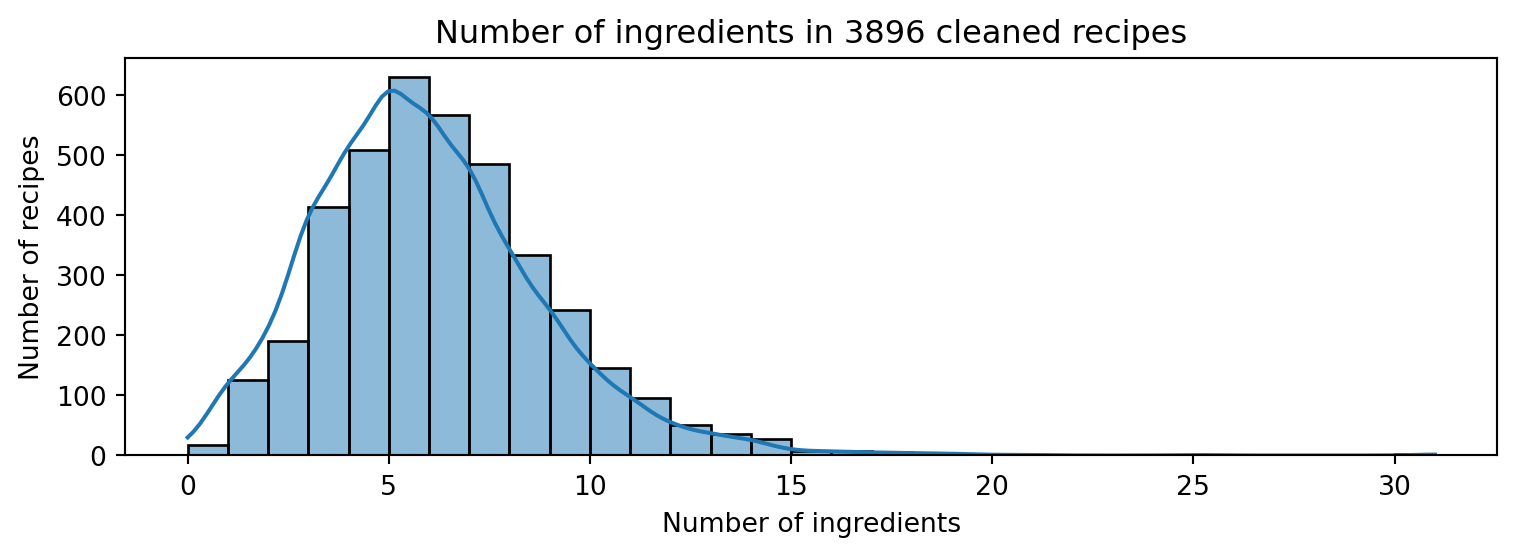

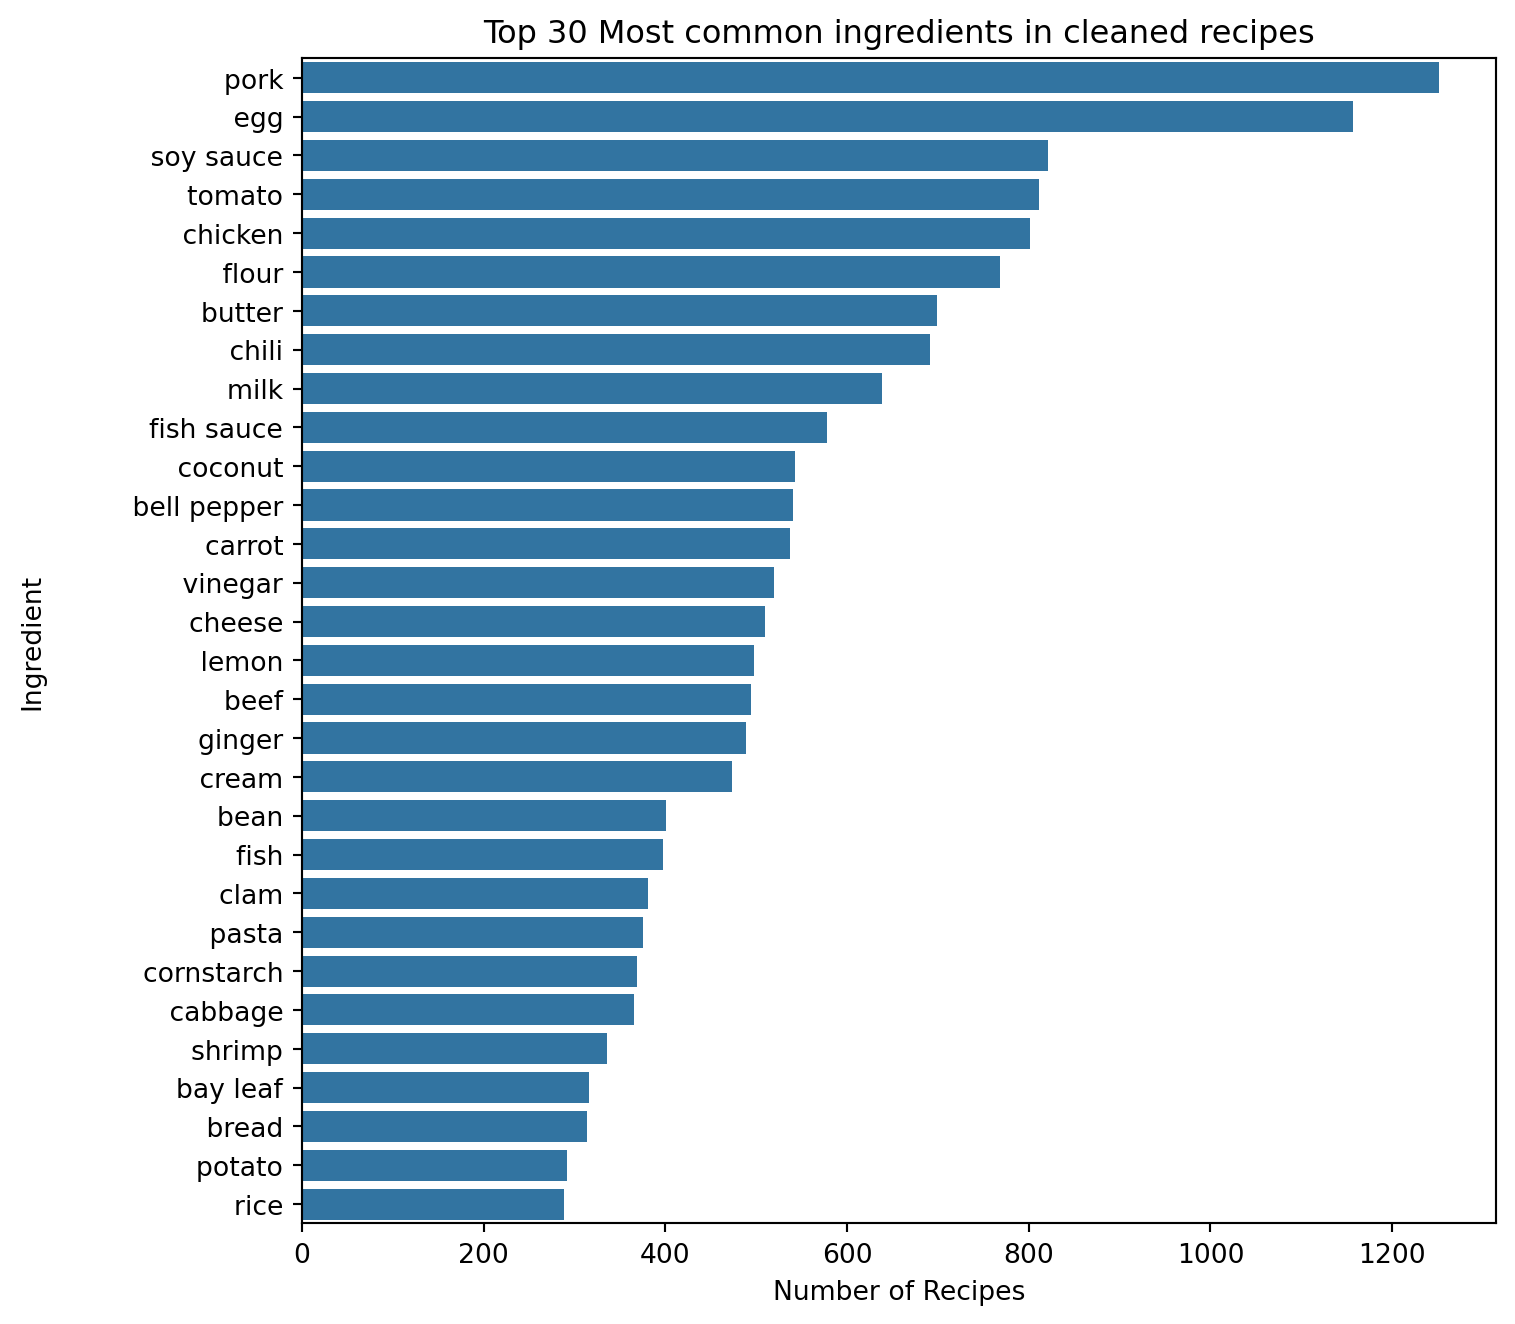

In [26]:
plot_ingredient_count_distribution(recipe_df.filtered_unique)
plot_common_ingredients(recipe_df.filtered_unique)

D:\codes\panlasang-pinoy-clustering\venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



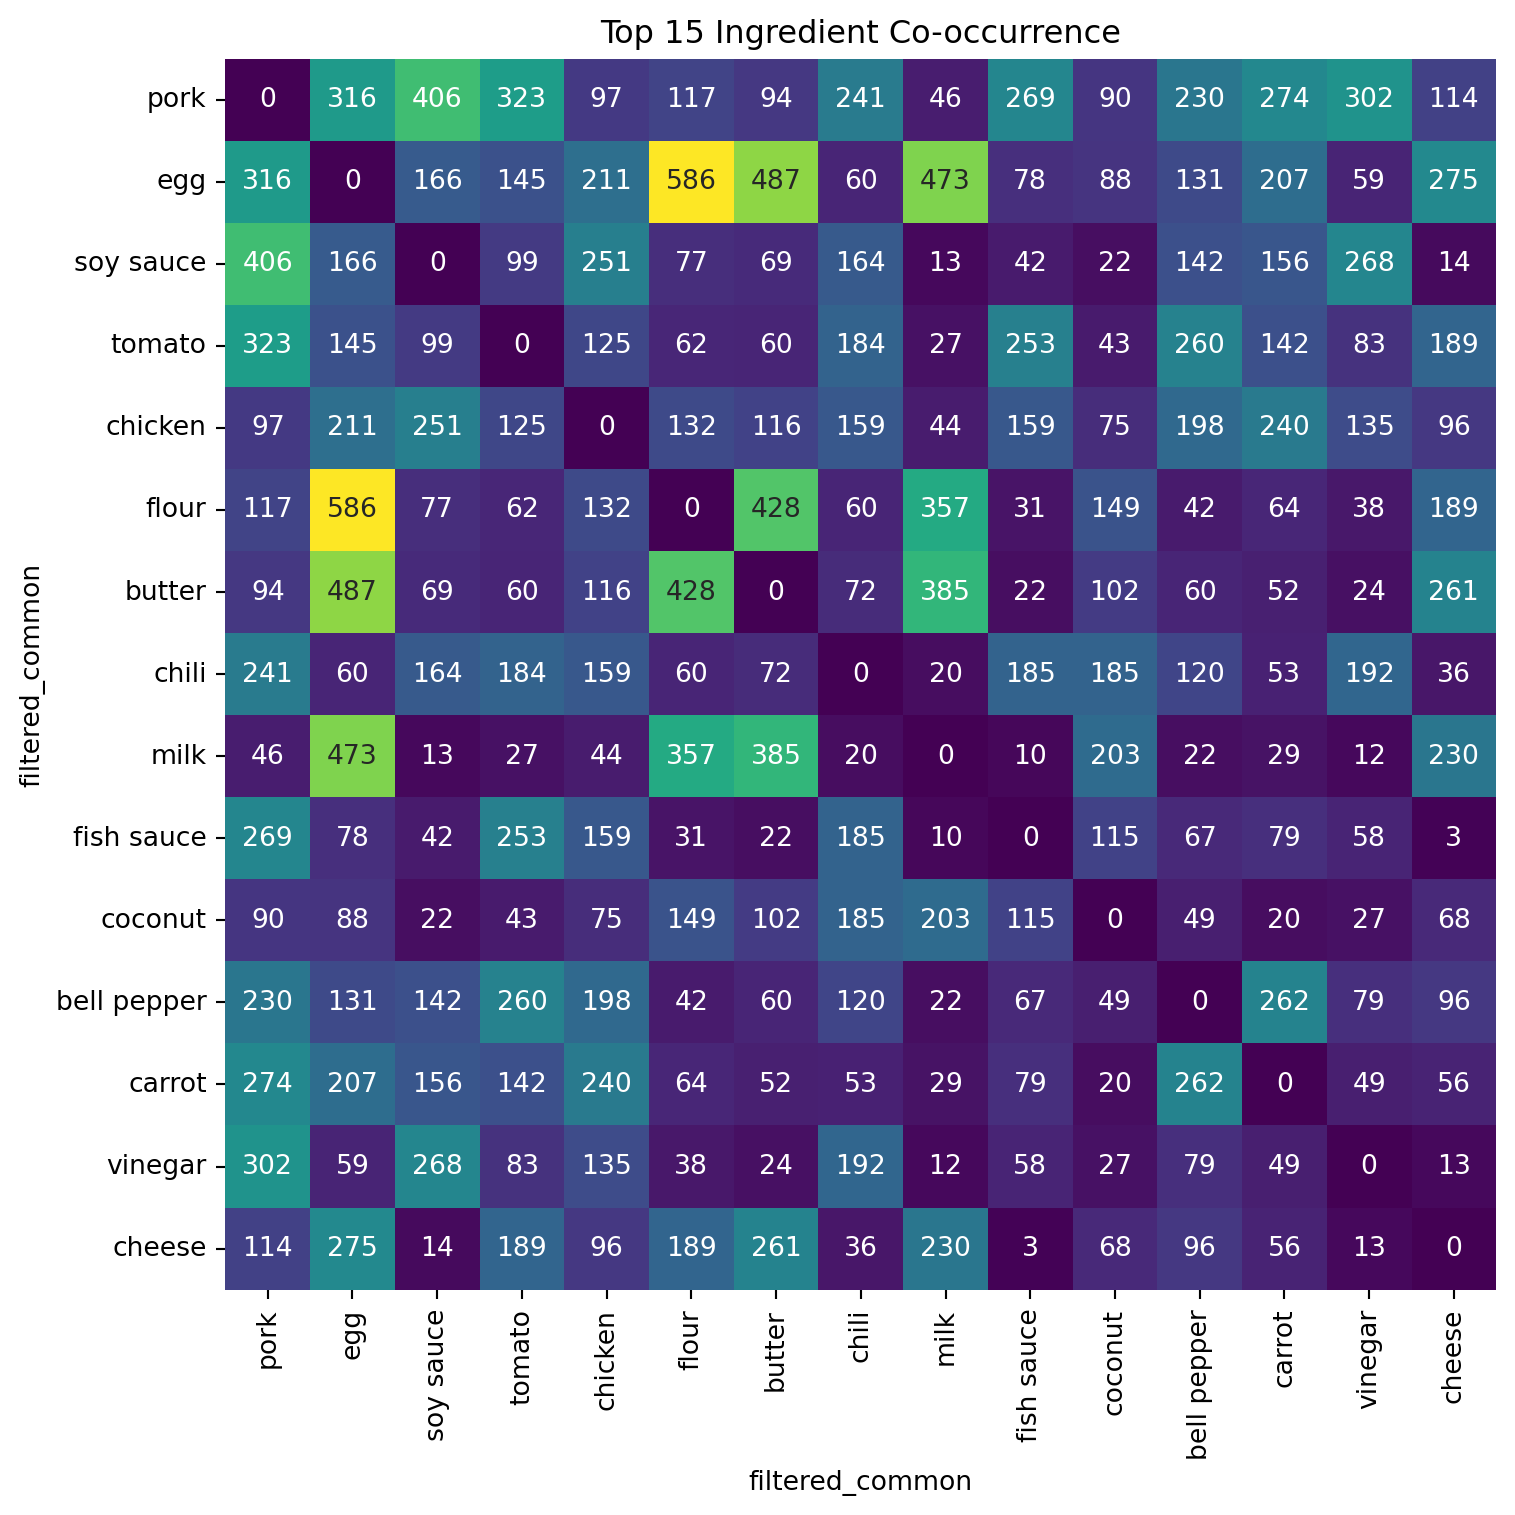

In [27]:
# Draw heatmap of top 30 ingredient co-occurrence
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(recipe_df.filtered_unique)
cooccurrence_matrix = X.T * X
cooccurrence_matrix.setdiag(0)

cooccurrence_df = pd.DataFrame(
    cooccurrence_matrix.toarray(),
    index=vectorizer.get_feature_names_out(),
    columns=vectorizer.get_feature_names_out(),
)

top_ingredients = ingredient_counts.head(15).index
top_cooccurrence_df = cooccurrence_df.loc[top_ingredients, top_ingredients]

plt.figure(figsize=(8, 8))
sns.heatmap(
    top_cooccurrence_df,
    cmap="viridis",
    annot=True,
    fmt="d",
    cbar=False,
)
plt.title("Top 15 Ingredient Co-occurrence")
plt.tight_layout()

plt.show()

## Association Analysis

### Convert DataFrame to one-hot encoded format


In [28]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(recipe_df.filtered_unique)
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
one_hot_df = one_hot_df.astype(bool)

one_hot_df.head()

,alcohol,anise,annatto,apple,asparagus,avocado,baking soda,banana,barbecue sauce,basil,...,tofu,tomato,turnip,vanilla,vegetable,vegetable broth,vinegar,wrapper,yam,yeast
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Find frequent itemsets


In [29]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(
    one_hot_df,
    min_support=0.01, #  Lower this value to get more frequent itemsets
    use_colnames=True,
)

frequent_itemsets.head()

,support,itemsets
0,0.047998,(alcohol)
1,0.013860,(anise)
2,0.021561,(annatto)
3,0.060062,(baking soda)
4,0.044661,(banana)


In [30]:
frequent_itemsets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   support   672 non-null    float64
 1   itemsets  672 non-null    object 
dtypes: float64(1), object(1)
memory usage: 10.6+ KB


### Generate association rules


In [31]:
from mlxtend.frequent_patterns import association_rules

rules_df = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.5,
)
rules_df = rules_df.round(3)

rules_df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(anise),(soy sauce),0.014,0.197,0.010,0.741,3.768,0.008,3.099,0.745
1,(annatto),(fish sauce),0.022,0.145,0.011,0.524,3.612,0.008,1.795,0.739
2,(baking soda),(butter),0.060,0.162,0.030,0.500,3.087,0.020,1.676,0.719
3,(baking soda),(egg),0.060,0.269,0.053,0.880,3.273,0.037,6.109,0.739
4,(baking soda),(flour),0.060,0.175,0.052,0.863,4.946,0.041,6.036,0.849


In [32]:
rules_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         543 non-null    object 
 1   consequents         543 non-null    object 
 2   antecedent support  543 non-null    float64
 3   consequent support  543 non-null    float64
 4   support             543 non-null    float64
 5   confidence          543 non-null    float64
 6   lift                543 non-null    float64
 7   leverage            543 non-null    float64
 8   conviction          543 non-null    float64
 9   zhangs_metric       543 non-null    float64
dtypes: float64(8), object(2)
memory usage: 42.6+ KB


In [33]:
cols_to_show = ["antecedents", "consequents", "support", "confidence", "lift"]
rules_df[cols_to_show].sort_values("confidence", ascending=False).head(10)

,antecedents,consequents,support,confidence,lift
400,"(bean, tamarind, okra)",(tomato),0.010,1.0,5.344
470,"(radish, tamarind, okra)",(tomato),0.011,1.0,5.344
488,"(spinach, radish, tamarind)",(tomato),0.010,1.0,5.344
264,"(radish, okra)",(tomato),0.012,1.0,5.344
274,"(tamarind, okra)",(tomato),0.013,1.0,5.344
480,"(spinach, tamarind, okra)",(tomato),0.010,1.0,5.344
281,"(spinach, radish)",(tomato),0.011,1.0,5.344
285,"(radish, tamarind)",(tomato),0.014,1.0,5.344
464,"(fish sauce, spinach, tamarind)",(tomato),0.010,1.0,5.344
385,"(radish, bean, okra)",(tomato),0.010,1.0,5.344


In [34]:
rules_df[cols_to_show].sort_values("lift", ascending=False).head(10)

,antecedents,consequents,support,confidence,lift
474,"(tomato, radish)","(tamarind, okra)",0.011,0.683,54.269
477,"(tamarind, okra)","(tomato, radish)",0.011,0.878,54.269
262,(radish),"(tamarind, okra)",0.011,0.597,47.485
472,"(tomato, tamarind, okra)",(radish),0.011,0.878,47.485
478,(radish),"(tomato, tamarind, okra)",0.011,0.597,47.485
260,"(tamarind, okra)",(radish),0.011,0.878,47.485
492,"(radish, tomato)","(spinach, tamarind)",0.010,0.635,46.673
491,"(spinach, tamarind)","(radish, tomato)",0.010,0.755,46.673
490,"(spinach, radish)","(tomato, tamarind)",0.010,0.952,44.705
476,"(tomato, tamarind)","(radish, okra)",0.011,0.518,42.945


In [35]:
rules_df[cols_to_show].sort_values("support", ascending=False).head(10)

,antecedents,consequents,support,confidence,lift
23,(flour),(egg),0.105,0.603,2.241
13,(butter),(egg),0.082,0.506,1.879
24,(milk),(egg),0.074,0.557,2.072
3,(baking soda),(egg),0.053,0.880,3.273
4,(baking soda),(flour),0.052,0.863,4.946
155,"(egg, butter)",(flour),0.049,0.602,3.448
154,"(flour, butter)",(egg),0.049,0.738,2.745
27,(vanilla),(egg),0.049,0.808,3.003
63,(baking soda),"(flour, egg)",0.046,0.774,7.350
62,"(baking soda, egg)",(flour),0.046,0.879,5.034


In [36]:
rules_df["antecedents"] = rules_df["antecedents"].apply(tuple)
rules_df["consequents"] = rules_df["consequents"].apply(tuple)

rules_df.to_csv("data/association_rules.csv", index=False)

## Visualization

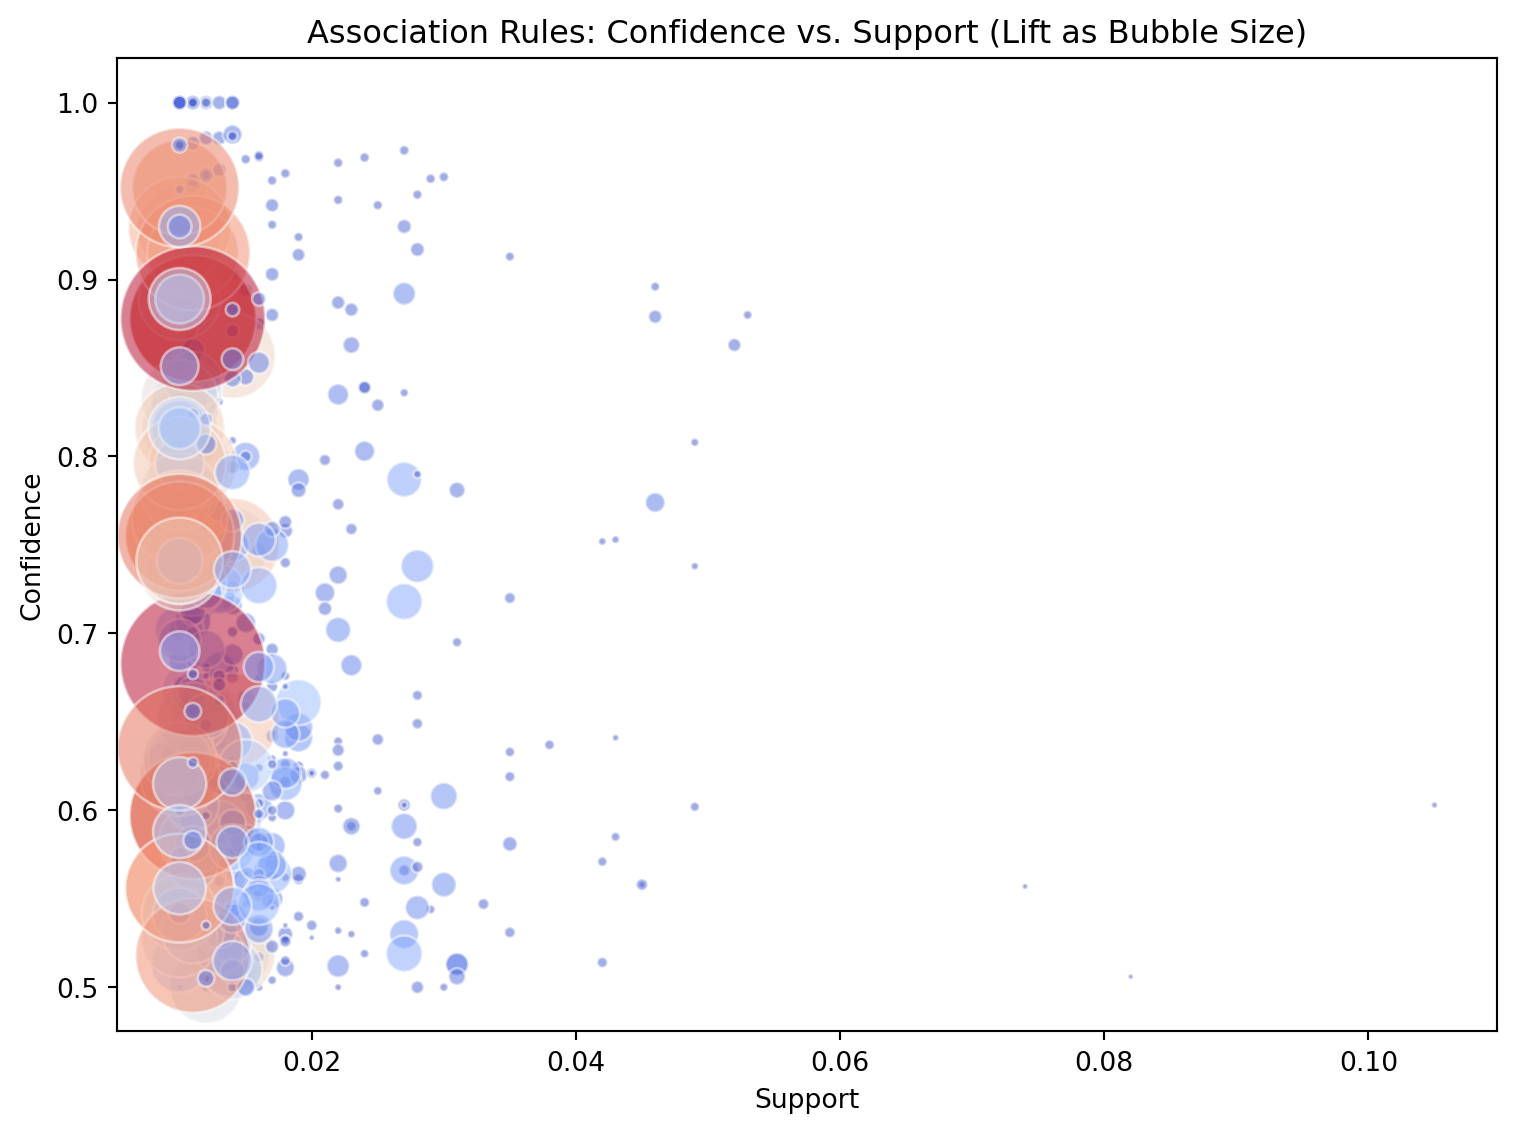

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(
    rules_df.support,
    rules_df.confidence,
    c=rules_df.lift,
    s=rules_df.lift**2,
    edgecolors="w",
    cmap="coolwarm",
    alpha=0.5,
)
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association Rules: Confidence vs. Support (Lift as Bubble Size)")
plt.tight_layout()
plt.show()

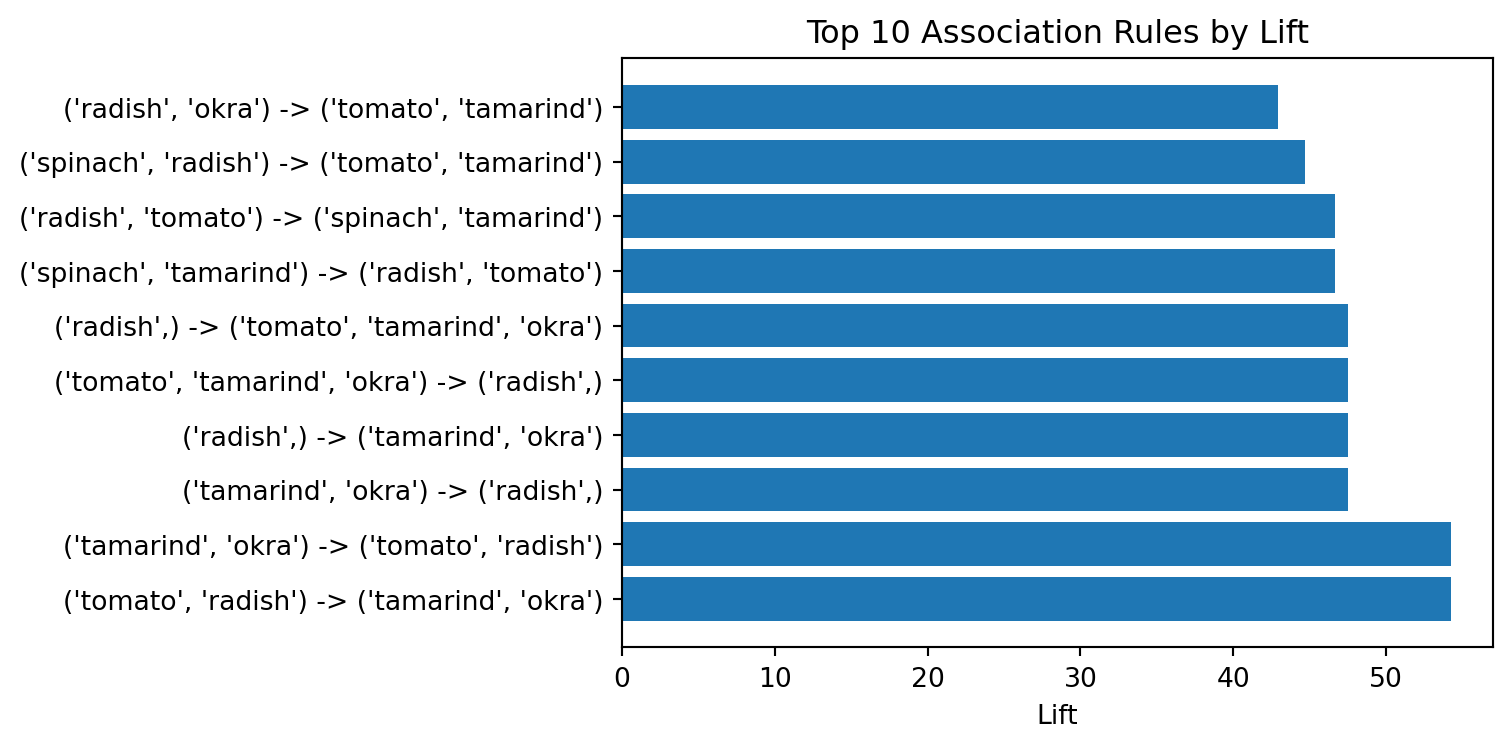

In [38]:
top_n = rules_df.nlargest(10, "lift")
plt.figure(figsize=(8, 4))
bars = plt.barh(
    top_n[["antecedents", "consequents"]].apply(
        lambda x: str(x.iloc[0]) + " -> " + str(x.iloc[1]), axis=1
    ),
    top_n["lift"],
)
plt.xlabel("Lift")
plt.title("Top 10 Association Rules by Lift")
plt.tight_layout()
plt.show()

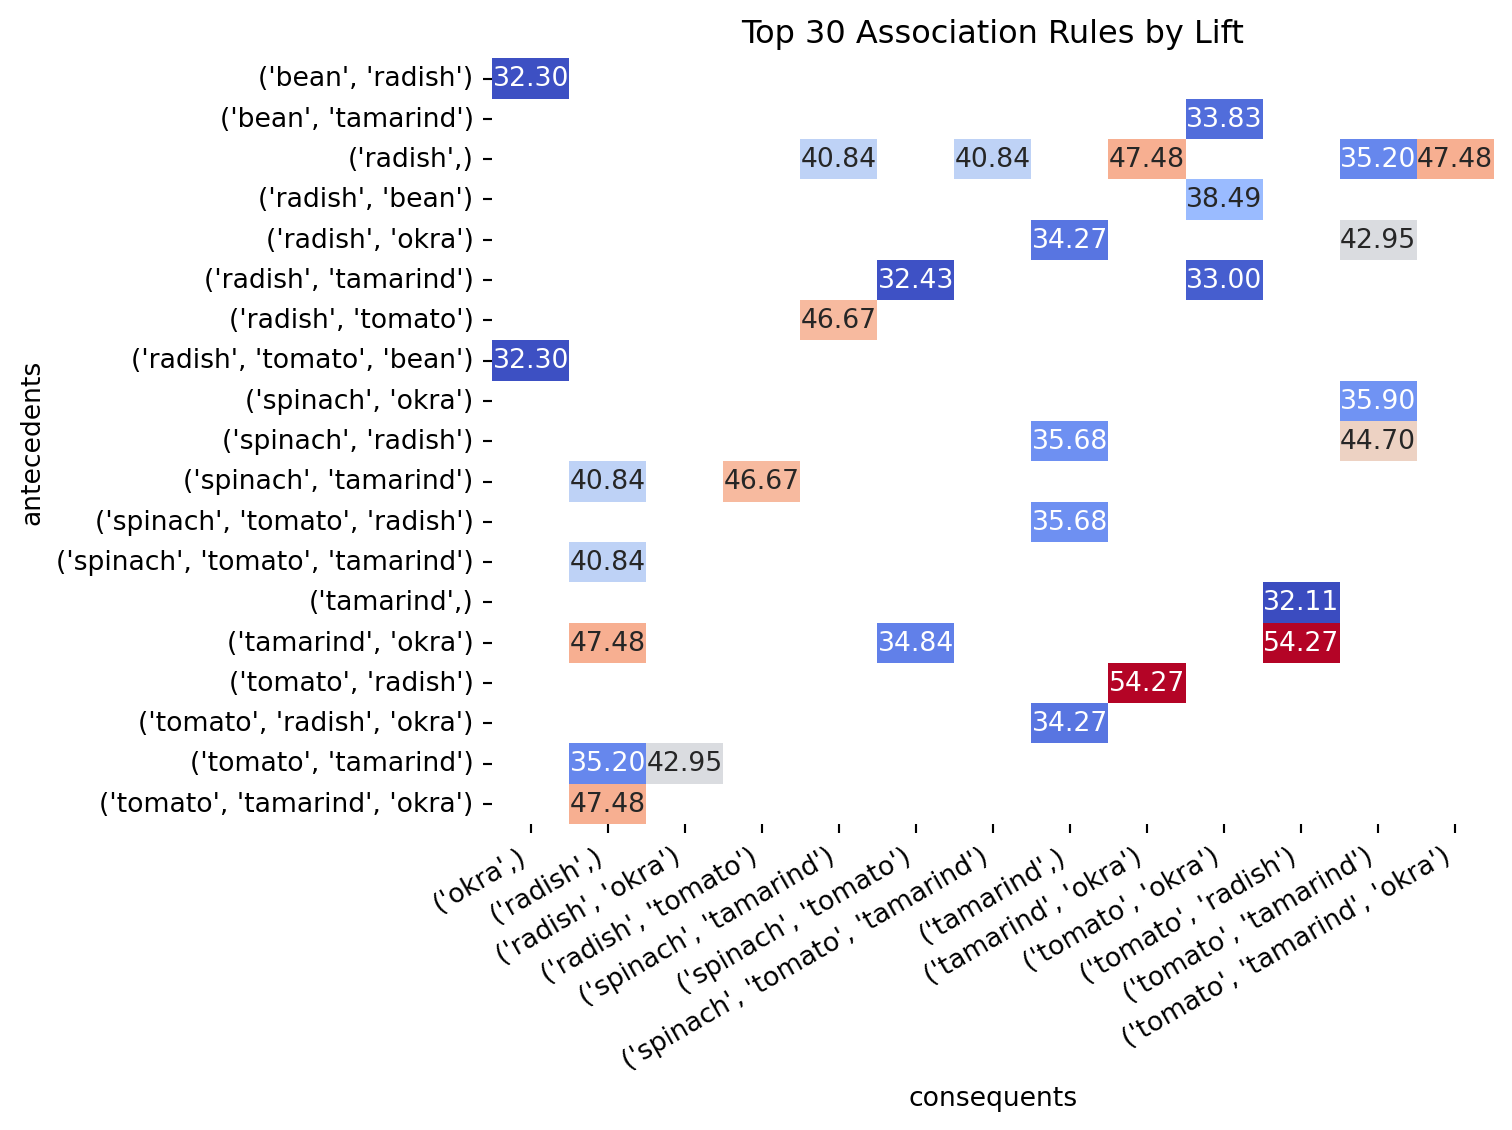

In [39]:
top_rules = rules_df.sort_values("lift", ascending=False).head(30)
pivot = top_rules.pivot(
    index="antecedents",
    columns="consequents",
    values="lift",
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Top 30 Association Rules by Lift")
plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.show()

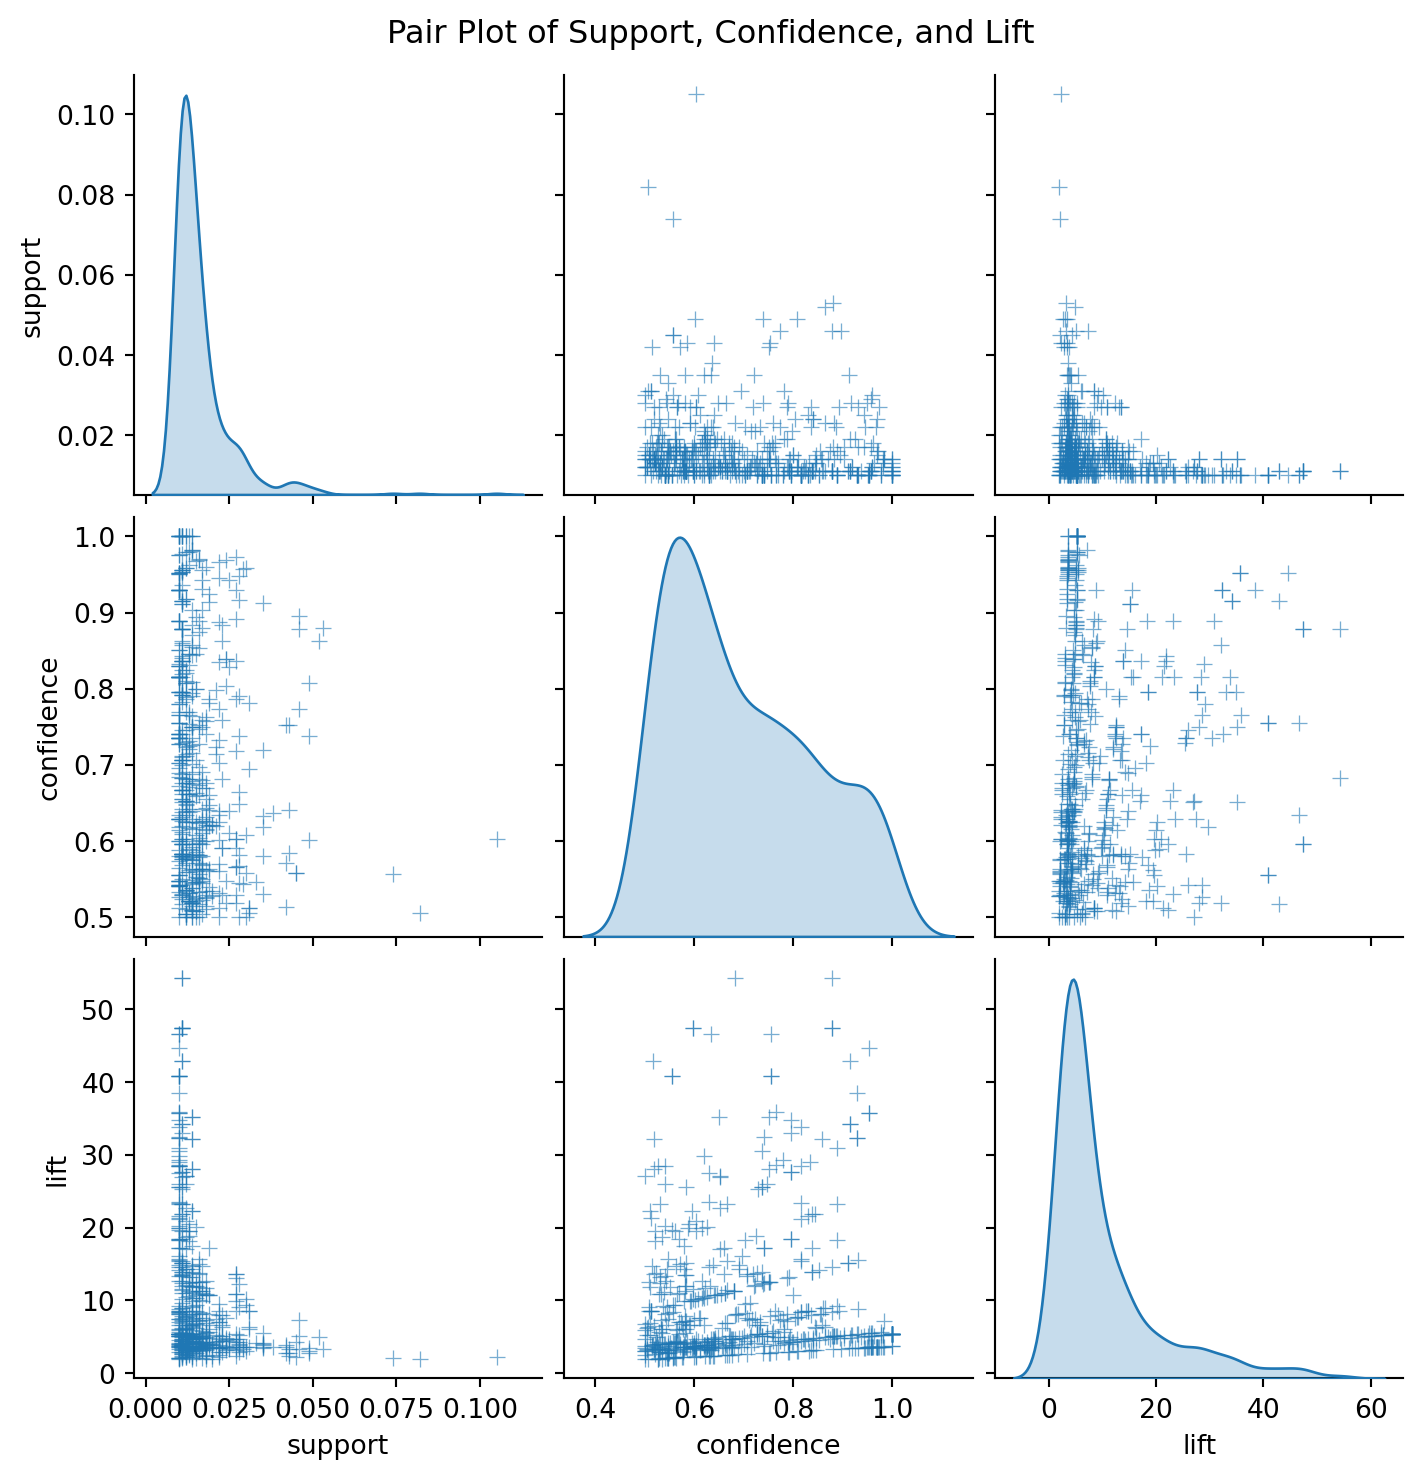

In [40]:
sns.pairplot(
    rules_df[["support", "confidence", "lift"]],
    diag_kind="kde",
    markers="+",
    plot_kws={"alpha": 0.6},
)
plt.suptitle("Pair Plot of Support, Confidence, and Lift", y=1.02)
plt.show()

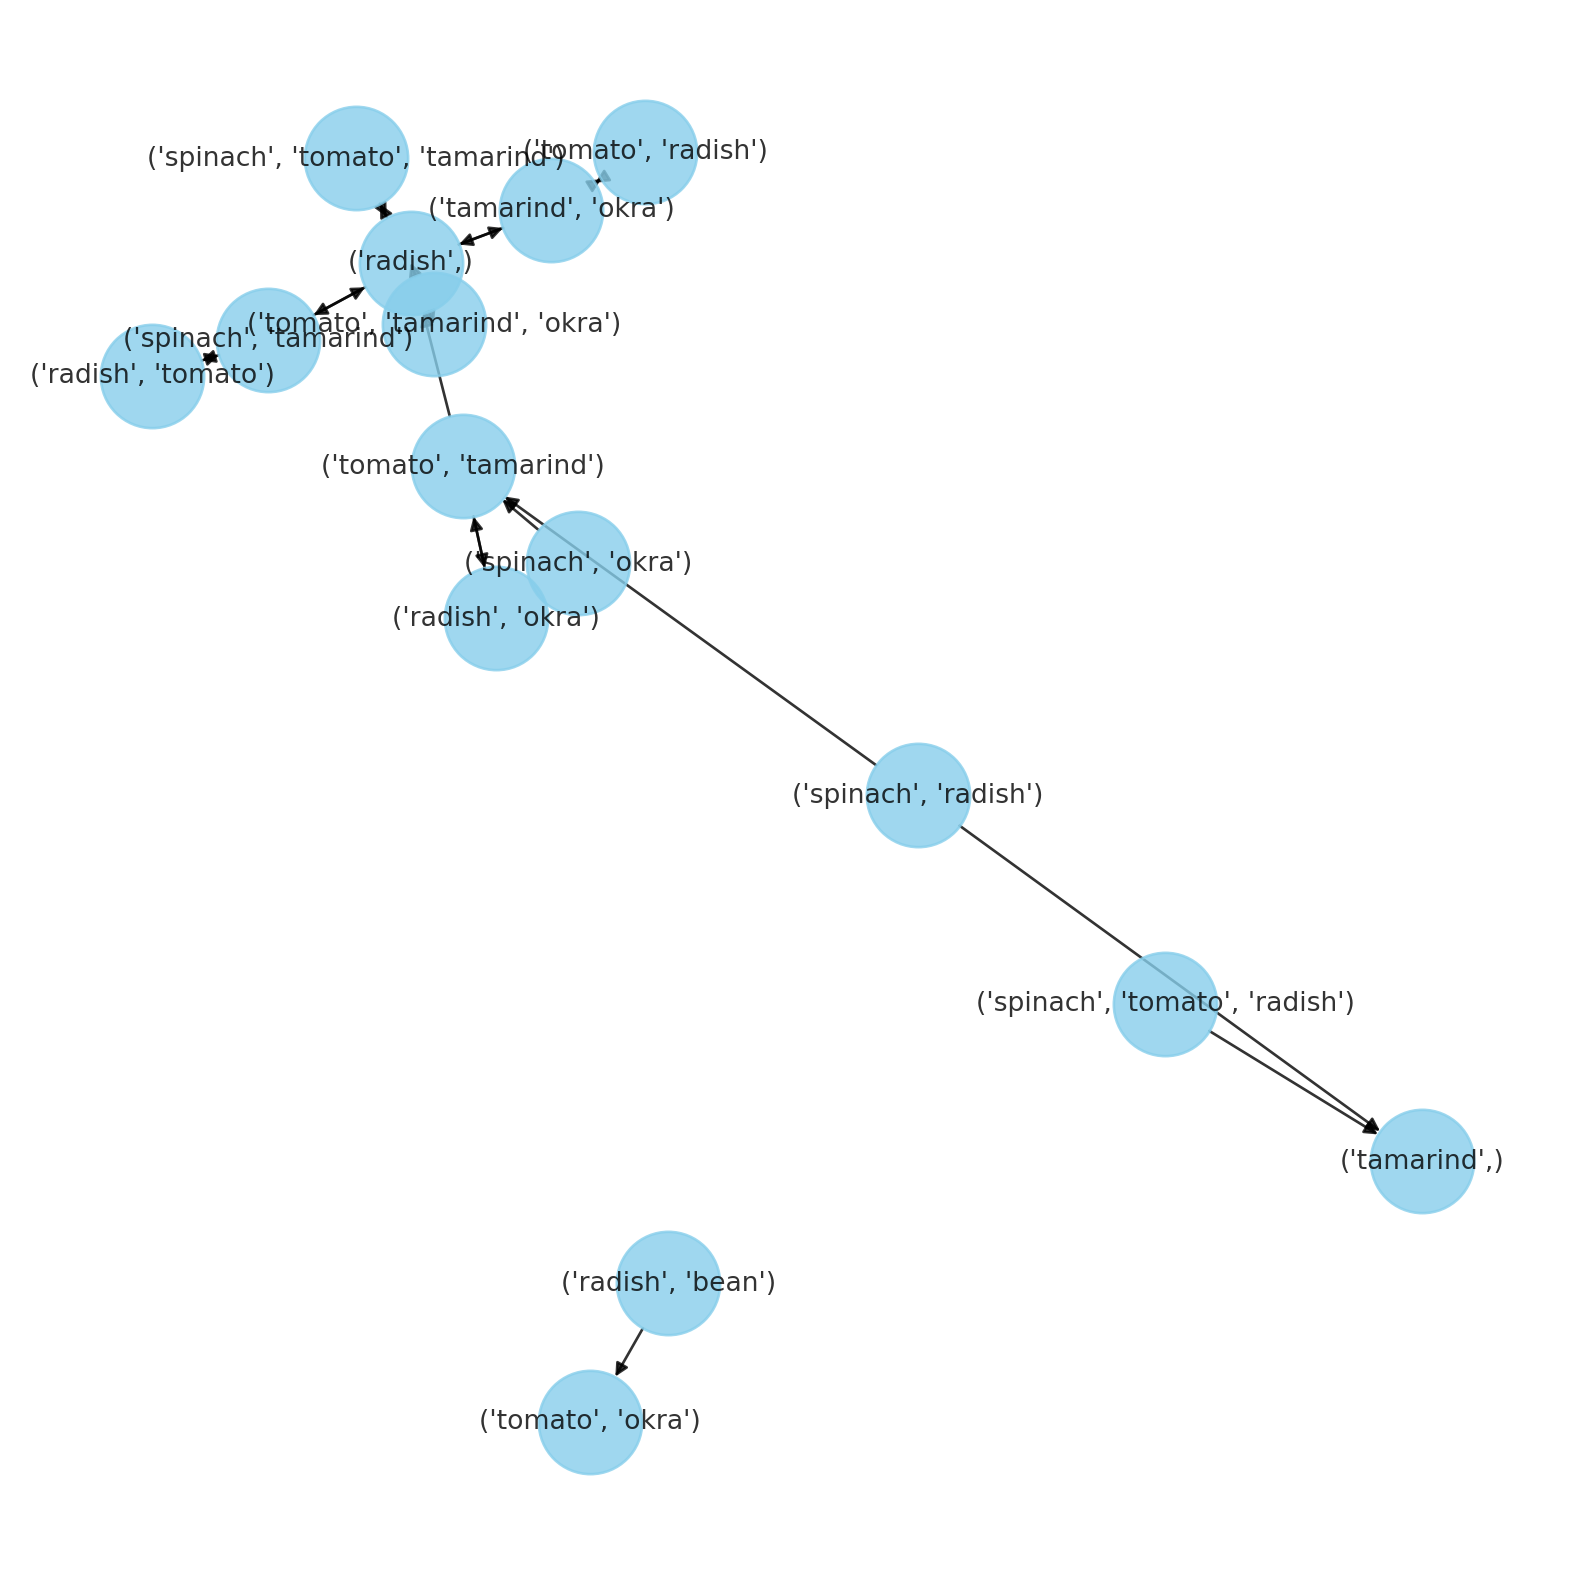

In [41]:
import matplotlib.pyplot as plt
import networkx as nx

# Sort rules_df by 'lift' in descending order and select top 30
top_rules_df = rules_df.sort_values("lift", ascending=False).head(20)

# Initialize directed graph and add edges from top_rules_df
G = nx.DiGraph()
for _, row in top_rules_df.iterrows():
    G.add_edge(
        str(row["antecedents"]),
        str(row["consequents"]),
        weight=row["lift"],
    )

# Draw the graph using Matplotlib
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.9, iterations=50)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="skyblue",
    node_size=1500,
    edge_color="k",
    linewidths=1,
    font_size=10,
    alpha=0.8,
    arrows=True,
)
plt.show()

In [42]:
import plotly.graph_objects as go
import networkx as nx

# Initialize graph and add edges from rules_df
G = nx.Graph()
for _, row in rules_df.iterrows():
    G.add_edge(
        str(row["antecedents"]),
        str(row["consequents"]),
        weight=row["lift"],
    )

# Compute spring layout for node positions
pos = nx.spring_layout(G, k=0.5, iterations=70)

# Prepare edge data for Plotly
edge_x = []
edge_y = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.3, color="#888"),
    hoverinfo="text",
    mode="lines",
)

# Calculate node degrees and prepare node hover text
node_degrees = dict(G.degree())
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_texts = []
node_connections = {
    node: {"outgoing": [], "incoming": []} for node in G.nodes()
}

for edge in G.edges(data=True):
    node_connections[edge[0]]["outgoing"].append(edge[1])
    node_connections[edge[1]]["incoming"].append(edge[0])

for node in G.nodes():
    outgoing = node_connections[node]["outgoing"]
    incoming = node_connections[node]["incoming"]
    hover_text = "<br><br>".join(
        [
            f"Node:<br>{node}",
            f"Consequent of ({len(incoming)}):<br>{'<br>'.join(incoming[:10])}",
            f"Antecedent of ({len(outgoing)}):<br>{'<br>'.join(outgoing[:10])}",
        ]
    )
    node_texts.append(hover_text)
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers",
    text=node_texts,
    hoverinfo="text",
    marker=dict(size=10, color="darkblue", line=dict(width=1, color="#fff")),
)

# Create and display figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title="Association Rule Network Graph",
        titlefont_size=16,
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=20, r=20, t=40),
        annotations=[
            dict(text="", showarrow=False, xref="paper", yref="paper")
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    ),
)
fig.show()